# Project 4: West Nile Virus
---

## Contents
- [Problem Statement](#Problem-Statement)
- [Loading files into DataFrame](#Loading-files-into-DataFrame)
- [Train DataFrame](#Train-DataFrame)
- [Spray DataFrame](#Spray-DataFrame)
- [Weather DataFrame](#Weather-DataFrame)
- [Test DataFrame](#Test-DataFrame)
- [Merging train and weather DataFrames](#Merging-train-and-weather-DataFrames)
- [Visualizing Traps onto the map ](#Visualizing-Traps-onto-the-map )
- [EDA visualization](#EDA-visualization)
- [Feature Selection](#Feature-Selection)
- [Modelling](#Modelling)
- [Conclusions](#Conclusions)

## Problem Statement
---

West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. 

Importing standard libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, plot_roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

from math import sin, cos, sqrt, atan2, radians

In [2]:
plt.style.use('seaborn')

In [3]:
# Predefining the data files in a dictionary for easy file maintenance
data_files = {
    'train' : '../assets/train.csv',
    'test' : '../assets/test.csv',
    'spray' : '../assets/spray.csv',
    'weather' : '../assets/weather.csv',
    'mapdata_rds' : '../assets/mapdata_copyright_openstreetmap_contributors.rds',
    'mapdata_txt' : '../assets/mapdata_copyright_openstreetmap_contributors.txt',
    'shp' : '../assets/Boundaries_cities/geo_export_095d1d3d-b302-4bae-8a12-f6f48cb71b9f.shp',
    'merged_data': '../assets/merged.csv',
    'submit' : '../assets/submission.csv'
}

In [4]:
# NA options to use for read_csv
na_opt = {
    'train' : None,
    'test' : None,
    'spray' : None,
    'weather' : ['M','-']
}

---
## Loading files into DataFrame
[top](#Contents)

In [5]:
# Prededefine dictionary to hold all data
all_data = dict()

In [6]:
# Loading csv files into DataFrame
for file in list(data_files.keys())[:4]:
    key = f'{file}_df'
    print('-----------------------------------')
    print(f'Loading DataFrame for {file} data')
    print('-----------------------------------')
    all_data[key] = pd.read_csv(data_files[file], na_values=na_opt[file])
    print(f'shape for {file}: {all_data[key].shape}\n')

-----------------------------------
Loading DataFrame for train data
-----------------------------------
shape for train: (10506, 12)

-----------------------------------
Loading DataFrame for test data
-----------------------------------
shape for test: (116293, 11)

-----------------------------------
Loading DataFrame for spray data
-----------------------------------
shape for spray: (14835, 4)

-----------------------------------
Loading DataFrame for weather data
-----------------------------------
shape for weather: (2944, 22)



In [7]:
# Checking column information
for data in all_data.keys():
    print('-----------------------------------')
    print(f'check column information for {data}')
    display(all_data[data].info())

-----------------------------------
check column information for train_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


None

-----------------------------------
check column information for test_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


None

-----------------------------------
check column information for spray_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


None

-----------------------------------
check column information for weather_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2933 non-null   float64
 5   Depart       1472 non-null   float64
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2940 non-null   float64
 8   Heat         2933 non-null   float64
 9   Cool         2933 non-null   float64
 10  Sunrise      1472 non-null   float64
 11  Sunset       1472 non-null   float64
 12  CodeSum      2944 non-null   object 
 13  Depth        1472 non-null   float64
 14  Water1       0 non-null      float64
 15  SnowFall     1472 non-null   object 
 16  PrecipTotal  2942 non-null   object 
 17  StnPressure  2

None

In [8]:
# Checking for Null
for data in all_data.keys():
    print('-----------------------------------')
    print(f'checking for null in {data}')
    display(all_data[data].isnull().sum())

-----------------------------------
checking for null in train_df


Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

-----------------------------------
checking for null in test_df


Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64

-----------------------------------
checking for null in spray_df


Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

-----------------------------------
checking for null in weather_df


Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise        1472
Sunset         1472
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

---
## Train DataFrame
[top](#Contents)

In [9]:
train_df = all_data['train_df']

In [10]:
# Convert column names into lowercase
train_df.columns = map(str.lower, train_df.columns)

---
95% of the traps were negative for West Nile Virus.
This means that our dataset is imbalanced.

In [11]:
# 95% of the traps were negative for WNV
train_df['wnvpresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

---
Merging of rows that were split when nummosquitos > 50

In [12]:
# check on the shape before merging the rows
train_df.shape

(10506, 12)

In [13]:
# Check for rows that have NumMosquitos == 50, potentially have to merge with another row
len(train_df[train_df['nummosquitos']>=50])

1019

In [14]:
train_df = train_df.groupby(['date','address','species','block','street',
                                 'trap','addressnumberandstreet',
                                 'latitude','longitude','addressaccuracy','wnvpresent'
                                ])['nummosquitos'].sum().reset_index(name='nummosquitos')

In [15]:
# check on the shape after merging the rows
train_df.shape

(8610, 12)

---
Converting Date to datetime datatype

In [16]:
# Converting Date column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
# Creating year and month columns, for easy analysis moving forward
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
# Checking datatypes for train_df
train_df.dtypes

date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
wnvpresent                         int64
nummosquitos                       int64
year                               int64
month                              int64
day                                int64
dtype: object

In [17]:
# Looking at the unique years contained in train_df
list(train_df['year'].unique())

[2007, 2009, 2011, 2013]

In [18]:
# Looking at data available across the years
train_df['year'].value_counts()

2007    2837
2013    2058
2009    1921
2011    1794
Name: year, dtype: int64

In [19]:
# Looking at data spread across the months
train_df['month'].value_counts(normalize=True).sort_index()

5     0.009408
6     0.155285
7     0.246225
8     0.329268
9     0.229152
10    0.030662
Name: month, dtype: float64

In [20]:
# weather stations information
weather_stns ={
    'station1' : {
        'name': "CHICAGO O'HARE INTERNATIONAL AIRPORT",
        'lon': -87.933,
        'lat': 41.995,
        'elev': 662
    },
    'station2' : {
        'name': "CHICAGO MIDWAY INTL ARPT",
        'lon': -87.752,
        'lat': 41.786,
        'elev': 612
    }
}

In [21]:
# (added 14 Sep 2020)
# Function to calculate distance between 2 sets of longitude and latitude
def cal_distance(lat1, lon1, lat2, lon2):
    """ 
    Function to calculate distance between 2 sets of longitude and latitude
    
    Parameters: 
		lat1 (float): latitude of the first location
        lon1 (float): longtitude of the first location
        lat2 (float): latitude of the second location
        lon2 (float): longtitude of the second location
  
    Returns: 
		float: distance between the 2 locations in km 
  
    """
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # 6373.0 approximate radius of earth in km
    return round(6373.0 * c, 4)

In [22]:
# (added 14 Sep 2020)
# Function to calculate the nearest weather station and distance
def nearest_stn(df):
    """ 
    Function to calculate the nearest weather station and distance
    
    Parameters: 
		df (DataFrame): DataFrame with holding the position information
  
    Returns: 
		None: 
  
    """
    for row in df.itertuples():
        index = row.Index
        lat = row.latitude
        lon = row.longitude
        
        stn1 = abs(cal_distance(lat, lon, 
                            weather_stns['station1']['lat'], 
                            weather_stns['station1']['lon']))
        stn2 = abs(cal_distance(lat, lon, 
                            weather_stns['station2']['lat'], 
                            weather_stns['station2']['lon']))
        
        if stn1 < stn2:
            df.loc[index, "station"] = 1
            df.loc[index, "stn_distance"] = stn1
        else:
            df.loc[index, "station"] = 2
            df.loc[index, "stn_distance"] = stn2
    return

In [23]:
# get nearest weather station for train_df
nearest_stn(train_df)

In [24]:
# distance between the 2 weather stations
dist = cal_distance(weather_stns['station1']['lat'],
                    weather_stns['station1']['lon'],
                    weather_stns['station2']['lat'], 
                    weather_stns['station2']['lon'])
print(f'Distance between the 2 weather stations is: {dist}km')

Distance between the 2 weather stations is: 27.6593km


---
## Spray DataFrame
[top](#Contents)

In [25]:
spray_df = all_data['spray_df']

In [26]:
# Convert column names into lowercase
spray_df.columns = map(str.lower, spray_df.columns)

In [27]:
# Converting Date column to datetime
spray_df['date'] = pd.to_datetime(spray_df['date'])

# Creating year and month columns
spray_df['year'] = spray_df['date'].dt.year
spray_df['month'] = spray_df['date'].dt.month
spray_df['day'] = spray_df['date'].dt.day
spray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14835 non-null  datetime64[ns]
 1   time       14251 non-null  object        
 2   latitude   14835 non-null  float64       
 3   longitude  14835 non-null  float64       
 4   year       14835 non-null  int64         
 5   month      14835 non-null  int64         
 6   day        14835 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 811.4+ KB


In [28]:
# Looking at the years available in spray data
list(spray_df['date'].dt.year.unique())

[2011, 2013]

In [29]:
# Looking at the months available in spray data
list(spray_df['date'].dt.month.unique())

[8, 9, 7]

In [30]:
spray_df['date'].value_counts(normalize=True)

2013-08-15    0.179845
2013-08-29    0.155174
2013-07-17    0.148433
2011-09-07    0.142501
2013-07-25    0.108325
2013-08-22    0.106977
2013-08-08    0.080553
2013-09-05    0.062285
2013-08-16    0.009505
2011-08-29    0.006404
Name: date, dtype: float64

In [31]:
spray_df.head()

,date,time,latitude,longitude,year,month,day
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011,8,29
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011,8,29
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011,8,29
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011,8,29
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011,8,29


In [32]:
spray_df['date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: date, dtype: int64

In [33]:
# distance between the spray info on 2011-08-29, seems very far away
dist = cal_distance(weather_stns['station1']['lat'],
                    weather_stns['station1']['lon'],
                    42.391623, -88.089163)
print(f'Distance between the 2 weather stations is: {dist}km')

Distance between the 2 weather stations is: 45.955km


In [34]:
# distance between the spray info on 2011-09-07, seems very far away
dist = cal_distance(weather_stns['station1']['lat'],
                    weather_stns['station1']['lon'],
                    41.988837, -87.817002)
print(f'Distance between the 2011-09-07 stations is: {dist}km')

Distance between the 2011-09-07 stations is: 9.6141km


---
## Weather DataFrame
[top](#Contents)

In [35]:
w_df = all_data['weather_df']

In [36]:
# Convert column names into lowercase
w_df.columns = map(str.lower, w_df.columns)

In [37]:
w_df.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,...,,0.0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,NaN,51,57.0,0.0,3.0,...,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,...,BR,0.0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,NaN,42,47.0,13.0,0.0,...,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,,0.0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9


In [38]:
# Converting date column into datetime datatype
w_df['date'] = pd.to_datetime(w_df['date'])

# Split Date (ojbect) into day, month and year
# This will be useful later when EDA and modelling are performed
w_df['year'] = w_df.date.dt.year
w_df['month'] = w_df.date.dt.month
w_df['day'] = w_df.date.dt.day

In [39]:
list(w_df['date'].dt.year.unique())

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]

In [40]:
# Check on the datatype
w_df.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                  float64
depart                float64
dewpoint                int64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
depth                 float64
water1                float64
snowfall               object
preciptotal            object
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir               int64
avgspeed              float64
year                    int64
month                   int64
day                     int64
dtype: object

From the output above, we can see that all columns are numerical except for CodeSum, SnowFall and PrecipTotal. `CodeSum` is the code for weather condition at a given day, so it is sensible that it is not numerical. However, the other 2 columns are ought to be numerical. Let's look into each of the 2 columns to find out if there is any invalid value that is causing it to be categorical.

---
### Snowfall and PrecipTotal Column

In [41]:
# Unique values of SnowFall
w_df.snowfall.unique()

array(['0.0', nan, '  T', '0.1'], dtype=object)

In [42]:
# Unique values of PrecipTotal
w_df.preciptotal.unique()

array(['0.00', '  T', '0.13', '0.02', '0.38', '0.60', '0.14', '0.07',
       '0.11', '0.09', '1.01', '0.28', '0.04', '0.08', '0.01', '0.53',
       '0.19', '0.21', '0.32', '0.39', '0.31', '0.42', '0.27', '0.16',
       '0.58', '0.93', '0.05', '0.34', '0.15', '0.35', nan, '0.40',
       '0.66', '0.30', '0.24', '0.43', '1.55', '0.92', '0.89', '0.17',
       '0.03', '1.43', '0.97', '0.26', '1.31', '0.06', '0.46', '0.29',
       '0.23', '0.41', '0.45', '0.83', '1.33', '0.91', '0.48', '0.37',
       '0.88', '2.35', '1.96', '0.20', '0.25', '0.18', '0.67', '0.36',
       '0.33', '1.28', '0.74', '0.76', '0.71', '0.95', '1.46', '0.12',
       '0.52', '0.64', '0.22', '1.24', '0.72', '0.73', '0.65', '1.61',
       '1.22', '0.50', '1.05', '2.43', '0.59', '2.90', '2.68', '1.23',
       '0.62', '6.64', '3.07', '1.44', '1.75', '0.82', '0.80', '0.86',
       '0.63', '0.55', '1.03', '0.70', '1.73', '1.38', '0.44', '1.14',
       '1.07', '3.97', '0.87', '0.78', '1.12', '0.68', '0.10', '0.61',
       '0.

Here we see that ' T' are present in both the columns. Checking through the data dictionary document shows that the code 'T' actually represents 'Trace' amount of either Snow or Precipitation. We can easily replace the value with 0 since it was only traced amount that was **not measurable by the sensory equipment.**

In [43]:
# Replacing SnowFall 'T' with 0
w_df['snowfall'] = w_df['snowfall'].replace('  T', 0).astype(float)

# Replacing PrecipTotal 'T' with 0
w_df['preciptotal'] = w_df['preciptotal'].replace('  T', 0).astype(float)

# Sanity check on the data type after cleaning
w_df.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                  float64
depart                float64
dewpoint                int64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
depth                 float64
water1                float64
snowfall              float64
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir               int64
avgspeed              float64
year                    int64
month                   int64
day                     int64
dtype: object

## Codesum Column

Only days with weather condition will be recorded in the dataset. Hence, empty strings in this column actually means that it is a weather-wise uneventful day. We can replace all empty string with 'NA' to indicate that.

In [44]:
# Checking on the composition of CodeSum
w_df.codesum.head()

0         
1         
2       BR
3    BR HZ
4         
Name: codesum, dtype: object

In [45]:
# Replace all empty string with 'NA'
w_df.codesum.replace(' ', 'NA', inplace=True)

In [46]:
# Sanity Check
w_df.codesum.head()

0       NA
1       NA
2       BR
3    BR HZ
4       NA
Name: codesum, dtype: object

## Data Exploration

In [47]:
w_df.station.value_counts()

1    1472
2    1472
Name: station, dtype: int64

In [48]:
# Station 1
w_df.groupby('station').get_group(1).isnull().sum()

station           0
date              0
tmax              0
tmin              0
tavg              0
depart            0
dewpoint          0
wetbulb           3
heat              0
cool              0
sunrise           0
sunset            0
codesum           0
depth             0
water1         1472
snowfall          0
preciptotal       0
stnpressure       2
sealevel          5
resultspeed       0
resultdir         0
avgspeed          0
year              0
month             0
day               0
dtype: int64

In [49]:
# Station 2
w_df.groupby('station').get_group(2).isnull().sum()

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           1
heat             11
cool             11
sunrise        1472
sunset         1472
codesum           0
depth          1472
water1         1472
snowfall       1472
preciptotal       2
stnpressure       2
sealevel          4
resultspeed       0
resultdir         0
avgspeed          3
year              0
month             0
day               0
dtype: int64

From the missing value above, we can see that `Water1` is totally missing from the dataframe. So we may just drop it straight away. However, there are many columns that are totally missing in Station 2, but not Station 1. 

In [50]:
# Dropping 'Water1' from the dataframe
w_df.drop('water1', axis=1, inplace=True)

In [51]:
w_df[w_df['date'] == '2007-05-03'][['tavg', 'depart', 'heat', 'cool','sunrise', 'sunset', 'depth', 'snowfall']]

,tavg,depart,heat,cool,sunrise,sunset,depth,snowfall
4,56.0,2.0,9.0,0.0,446.0,1851.0,0.0,0.0
5,58.0,NaN,7.0,0.0,NaN,NaN,NaN,NaN


In [52]:
w_df[w_df['date'] == '2007-07-03'][['tavg', 'depart', 'heat', 'cool','sunrise', 'sunset', 'depth', 'snowfall']]

,tavg,depart,heat,cool,sunrise,sunset,depth,snowfall
126,72.0,0.0,0.0,7.0,421.0,1931.0,0.0,0.0
127,73.0,NaN,0.0,8.0,NaN,NaN,NaN,NaN


In [53]:
# Forward filling to replace all missing value at Station 2 with Station 1 data
w_df.fillna(method='ffill', inplace=True)

In [54]:
w_df[w_df['date'] == '2007-05-03'][['tavg', 'depart', 'heat', 'cool','sunrise', 'sunset', 'depth', 'snowfall']]

,tavg,depart,heat,cool,sunrise,sunset,depth,snowfall
4,56.0,2.0,9.0,0.0,446.0,1851.0,0.0,0.0
5,58.0,2.0,7.0,0.0,446.0,1851.0,0.0,0.0


---
### Creating time lag fields

In [55]:
# setting date as index
w_df.set_index('date', inplace=True)

In [56]:
lag_df = pd.DataFrame()
new_feats = ['tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal']
suffix = '_wk1'
shift = 7

for yr in w_df.index.year.unique():
    tmp_df = w_df[w_df.index.year==yr].copy()
    print(f'\nw_df shape for {yr} is {tmp_df.shape}')
    for feat in new_feats:
        tmp_df[f'{feat}{suffix}'] = tmp_df[feat].shift(shift)
    tmp_df.dropna(axis=0,inplace=True)
    lag_df = pd.concat([lag_df, tmp_df])


w_df shape for 2007 is (368, 23)

w_df shape for 2008 is (368, 23)

w_df shape for 2009 is (368, 23)

w_df shape for 2010 is (368, 23)

w_df shape for 2011 is (368, 23)

w_df shape for 2012 is (368, 23)

w_df shape for 2013 is (368, 23)

w_df shape for 2014 is (368, 23)


In [57]:
# assign lag_df back to w_df
w_df = lag_df

---
## Test DataFrame
[top](#Contents)

In [58]:
test_df = all_data['test_df']

In [59]:
# Convert column names into lowercase
test_df.columns = map(str.lower, test_df.columns)
test_df.set_index('id', inplace=True)
# Converting date column into datetime datatype
test_df['date'] = pd.to_datetime(test_df['date'])

In [60]:
test_df.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy
id,,,,,,,,,,
1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


---
## Merging train and weather DataFrames
[top](#Contents)

In [61]:
# check on shape before merging
print(f'train_df shape: {train_df.shape}')
print(f'w_df shape:\t{w_df.shape}')

train_df shape: (8610, 17)
w_df shape:	(2888, 31)


In [62]:
# merging of train_df and w_df 
merged_df = pd.merge(train_df, w_df, on=['date','station'])

In [63]:
merged_df.shape

(8610, 47)

In [64]:
merged_df.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,...,month_y,day_y,tmax_wk1,tmin_wk1,tavg_wk1,dewpoint_wk1,wetbulb_wk1,heat_wk1,cool_wk1,preciptotal_wk1
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,5,29,65.0,49.0,57.0,55.0,56.0,8.0,0.0,1.01
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,5,29,65.0,49.0,57.0,55.0,56.0,8.0,0.0,1.01
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,...,5,29,65.0,49.0,57.0,55.0,56.0,8.0,0.0,1.01
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,...,5,29,65.0,49.0,57.0,55.0,56.0,8.0,0.0,1.01
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,...,5,29,65.0,49.0,57.0,55.0,56.0,8.0,0.0,1.01


In [65]:
# check on unique values for snowfall and depth columns 
print(f'unqiue values for snowfall: {merged_df["snowfall"].unique()}')
print(f'unqiue values for depth: {merged_df["depth"].unique()}')

unqiue values for snowfall: [0.]
unqiue values for depth: [0.]


In [66]:
# drop duplicated year, month and day columns
merged_df.drop(['year_y', 'month_y', 'day_y'], axis=1, inplace=True)
# drop snowfall and depth as both columns contains only 0
merged_df.drop(['snowfall', 'depth'], axis=1, inplace=True)

In [67]:
# remove column suffix added during merging
merged_df.columns = merged_df.columns.str.replace('_x', '')

### split the codesum values and encode them into columns

In [68]:
# Function to encode the codesum column
def codesum_encode(df):
    """ 
    Function to encode the codesum column
    
    Parameters: 
		df (DataFrame): DataFrame to be processed
  
    Returns: 
		None: 
  
    """
    cs = []
    for code_str in df["codesum"].unique():
        cs.extend(code_str.lower().split(' '))
    cs = list(set(cs))
    print(f'unique codesum to be encoded to columns {cs}')
    for code in cs:
        df[f'cs_{code}'] = df["codesum"].map(lambda x : 1 if code in x else 0)
    return

In [69]:
# check on the unique values in codesum
print(f'unqiue values for codesum: {merged_df["codesum"].unique()}')
# encode codesum column
codesum_encode(merged_df)

unqiue values for codesum: ['BR HZ' 'RA BR' 'TSRA BR HZ VCTS' 'NA' 'TS TSRA RA BR HZ VCTS'
 'TSRA RA BR VCTS' 'DZ BR' 'RA BR HZ' 'HZ' 'VCTS' 'TSRA RA DZ BR HZ'
 'TSRA BR HZ' 'TSRA RA' 'TS TSRA RA BR' 'TSRA RA BR' 'BR' 'TSRA HZ' 'TSRA'
 'RA' 'TS TSRA BR' 'RA DZ BR' 'TS TSRA BR HZ' 'TS TSRA RA VCTS' 'TSRA BR'
 'TS' 'TS BR' 'FG BR HZ' 'TS TSRA RA FG BR HZ']
unique codesum to be encoded to columns ['vcts', 'hz', 'na', 'dz', 'br', 'ra', 'fg', 'tsra', 'ts']


### Encode and new features

In [70]:
# Function to encode features
def features_encode(df, pos_traps):
    """ 
    Function to encode features
    carrier column 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 
    'CULEX PIPIENS' coded to 1 other species coded to 0
    loc column latitube * longitude
    positive_trap coded to 1 if WNV was present in trap
    
    Parameters: 
		df (DataFrame): DataFrame to be processed
        pos_traps (list): List of positive traps in train data
  
    Returns: 
		None: 
  
    """
    df['carrier'] = df['species'].map(lambda x : 1 if 'RESTUANS' in x or 'PIPIENS' in x else 0)
    df['loc'] = df['latitude']* df['longitude']
    df['positive_trap'] = df['trap'].map(lambda t : 1 if t in pos_traps else 0)
    return

In [71]:
# List of traps that tested positive for WNV
pos_traps = list(train_df[train_df['wnvpresent']==1]['trap'].unique())

In [72]:
# check on the unique values in species
print(f'unqiue values for species: {merged_df["species"].unique()}')
# encode features 
features_encode(merged_df, pos_traps)

unqiue values for species: ['CULEX PIPIENS/RESTUANS' 'CULEX RESTUANS' 'CULEX PIPIENS'
 'CULEX SALINARIUS' 'CULEX TERRITANS' 'CULEX TARSALIS' 'CULEX ERRATICUS']


In [73]:
merged_df.to_csv(data_files['merged_data'], index=False)

In [74]:
merged_df.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,...,cs_na,cs_dz,cs_br,cs_ra,cs_fg,cs_tsra,cs_ts,carrier,loc,positive_trap
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,0,0,0,0,0,0,0,1,-3669.828863,1
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,0,0,0,0,0,0,0,1,-3669.828863,1
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,...,0,0,0,0,0,0,0,1,-3669.182171,1
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,...,0,0,0,0,0,0,0,1,-3672.428319,1
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,...,0,0,0,0,0,0,0,1,-3677.852055,0


---
### Merging Train and Test data for analysis
This merged dataframe is only for analysis not for train the models

In [75]:
# tr_df = train_df[['date', 'address', 'species', 'block', 'street', 'trap', 
#           'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy']]
# ts_df = test_df[['date', 'address', 'species', 'block', 'street', 'trap', 
#           'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy']]

In [76]:
# merged_trts_df = pd.concat([tr_df, ts_df], ignore_index=True)

In [77]:
# nearest_stn(merged_trts_df)

---
## Merging spray data

In [78]:
spray_df['date'].dt.year.unique()

array([2011, 2013], dtype=int64)

In [79]:
# (added 16 Sep 2020)
# Function to calculate the nearest spray time and distance
def nearest_spray(df, s_df):
    """ 
    Function to calculate the nearest spray time and distance
    
    Parameters: 
		df (DataFrame): DataFrame with holding the position information
        s_df (): DataFrame with the spray information
  
    Returns: 
		None: 
  
    """
    for i in range(len(df)):
        
        lat = df.loc[i, "Latitude"]
        lon = df.loc[i, "Longitude"]
        
        stn1 = abs(cal_distance(lat, lon, 
                            weather_stns['station1']['lat'], 
                            weather_stns['station1']['lon']))
        stn2 = abs(cal_distance(lat, lon, 
                            weather_stns['station2']['lat'], 
                            weather_stns['station2']['lon']))
        
        if stn1 < stn2:
            df.loc[i, "Station"] = 1
            df.loc[i, "stn_distance"] = stn1
        else:
            df.loc[i, "Station"] = 2
            df.loc[i, "stn_distance"] = stn2
    return

In [80]:
## WORK IN PROGRESS

---
## Analysis of the traps

In [81]:
# checking for traps that have moved
for trap in list(train_df['trap'].unique()):
    chk_trap = train_df[train_df['trap']==trap][['trap','latitude','longitude']].copy()
    chk_trap.drop_duplicates(['trap','latitude','longitude'], keep='last', inplace=True)
    if len(chk_trap) > 1:
        display(chk_trap)

,trap,latitude,longitude
2592,T009,41.981964,-87.812827
8590,T009,41.992478,-87.862995


,trap,latitude,longitude
2695,T035,41.836644,-87.677737
8571,T035,41.763733,-87.742302


In [82]:
# checking on why location is different for T009
mask = (train_df['trap']=='T009') & (train_df['latitude']<41.99)
train_df[mask][['date', 'trap', 'species', 'addressnumberandstreet','latitude','longitude','nummosquitos']]

,date,trap,species,addressnumberandstreet,latitude,longitude,nummosquitos
79,2007-06-05,T009,CULEX RESTUANS,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,2
265,2007-07-02,T009,CULEX RESTUANS,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,2
400,2007-07-11,T009,CULEX PIPIENS/RESTUANS,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,1
401,2007-07-11,T009,CULEX RESTUANS,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,14
654,2007-07-27,T009,CULEX PIPIENS,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,1
655,2007-07-27,T009,CULEX PIPIENS/RESTUANS,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,1
656,2007-07-27,T009,CULEX RESTUANS,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,1
891,2007-08-01,T009,CULEX PIPIENS,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,34
892,2007-08-01,T009,CULEX PIPIENS/RESTUANS,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,8
893,2007-08-01,T009,CULEX RESTUANS,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,2


Check on traps with WNV positive across the years

In [83]:
mask = (train_df['year']==2007) & (train_df['wnvpresent']==1)
train_df[mask][['trap']].value_counts().head()

trap
T115    12
T138     9
T002     7
T011     7
T086     7
dtype: int64

In [84]:
mask = (train_df['year']==2009) & (train_df['wnvpresent']==1)
train_df[mask][['trap']].value_counts().head()

trap
T903    2
T900    2
T095    2
T230    1
T228    1
dtype: int64

In [85]:
mask = (train_df['year']==2011) & (train_df['wnvpresent']==1)
train_df[mask][['trap']].value_counts().head()

trap
T900    12
T903     7
T223     5
T003     3
T225     2
dtype: int64

In [86]:
mask = (train_df['year']==2013) & (train_df['wnvpresent']==1)
train_df[mask][['trap']].value_counts().head()

trap
T900    15
T225     8
T013     8
T235     7
T003     7
dtype: int64

In [87]:
#### WORK IN PROGRESS

---
## Visualizing Traps onto the map 
[top](#Contents)

In [88]:
# Reading the shp file
street_map = gpd.read_file(data_files['shp'])

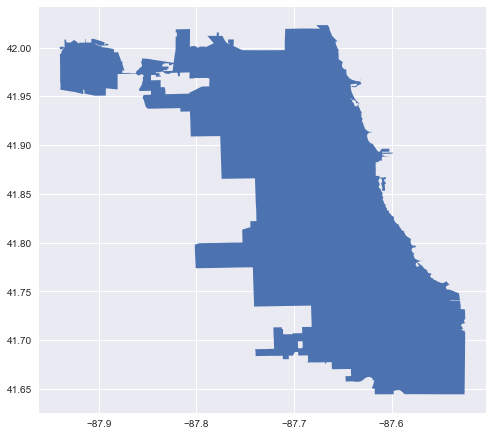

In [89]:
# Plotting basic shape of the map
fig,ax = plt.subplots(figsize = (8,8))
street_map.plot(ax=ax);

---
### Preparing GeoDataFrames for plotting into map

In [90]:
# init Coordinate Reference Systems
crs = {'init': 'epsg:4326'}

# Converting Latitude and Longitude to geo points
geo = [Point(xy) for xy in zip(train_df['longitude'], train_df['latitude'])]
# Creating a GeoDataFrame for train data
geo_df = gpd.GeoDataFrame(train_df, crs=crs, geometry=geo)

In [91]:
# Preparing station locations to be plotted
station = {'station': ['Station1', 'Station2'], 'geometry': [Point(-87.933,41.995), Point(-87.752,41.786)]}
# Creating GeoDataFrame for weather station data
geo_stn = gpd.GeoDataFrame(station, crs=crs)

In [92]:
# Converting spray locations into geo points
geo_s = [Point(xy) for xy in zip(spray_df['longitude'], spray_df['latitude'])]
# Creating GeoDataFrame for spray data
geo_spray = gpd.GeoDataFrame(spray_df, crs=crs, geometry=geo_s)

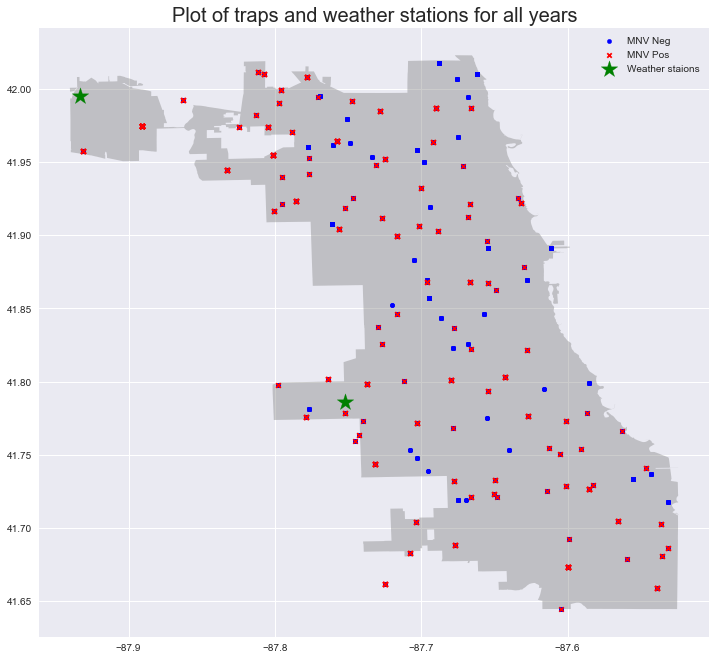

In [93]:
# Plotting the weather stations with postive and negative classes into the map
fig,ax = plt.subplots(figsize = (12,12))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['wnvpresent']==0].plot(ax=ax, markersize=20, color='blue',marker='o', label='MNV Neg')
geo_df[geo_df['wnvpresent']==1].plot(ax=ax, markersize=20, color='red',marker='x', label='MNV Pos')
geo_stn.plot(ax=ax, markersize=300, color='green', marker='*', label='Weather staions');
plt.title('Plot of traps and weather stations for all years', fontdict={'fontsize':20})
plt.legend();

---
## Plotting with Spray information

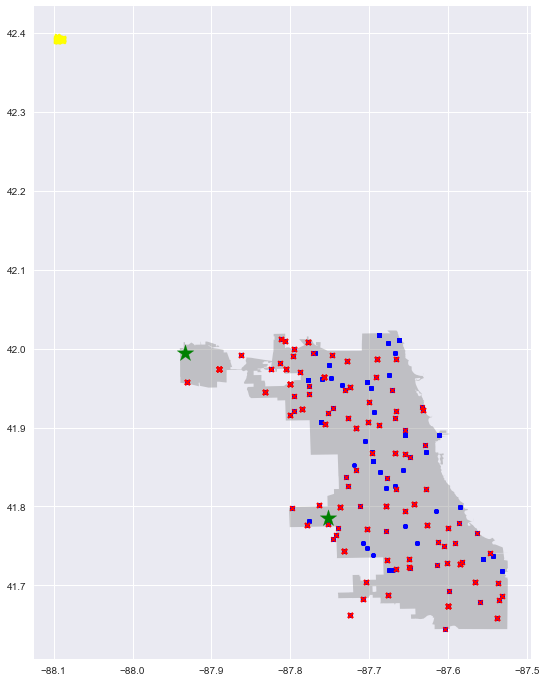

In [94]:
# spray location on date '2011-08-29' 
fig,ax = plt.subplots(figsize = (12,12))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_spray[geo_spray['date']=='2011-08-29'].plot(ax=ax, markersize=20, color='yellow',marker='x')
geo_df[geo_df['wnvpresent']==0].plot(ax=ax, markersize=20, color='blue',marker='o', label='Neg')
geo_df[geo_df['wnvpresent']==1].plot(ax=ax, markersize=20, color='red',marker='x', label='Pos')
geo_stn.plot(ax=ax, markersize=300, color='green',marker='*');

The location of spray was quite off as it was not within the city of Chicago. <br>
There may be errors in the data and we may want to exclude it.

In [95]:
# filtering out 2011-08-29 spray data for these plots
geo_spray = geo_spray[geo_spray['date']!='2011-08-29']

---
### Plot traps on the map across years

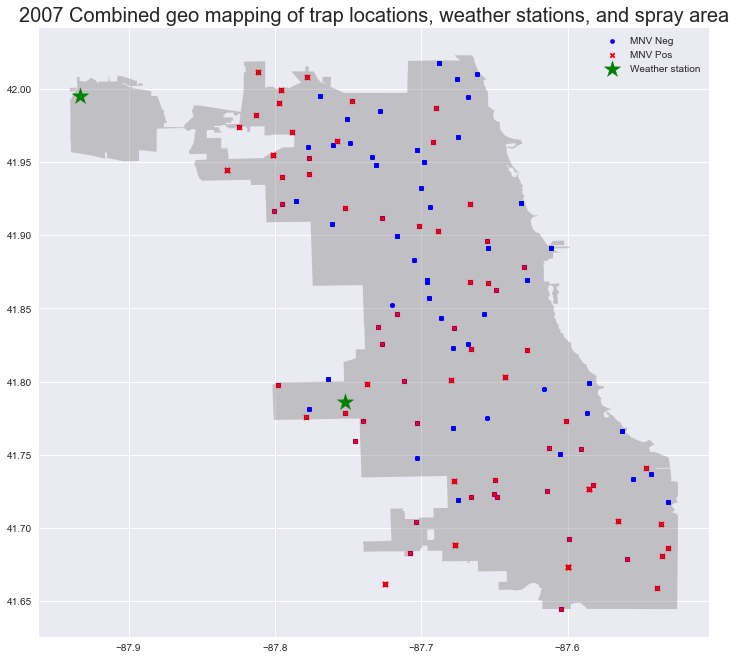

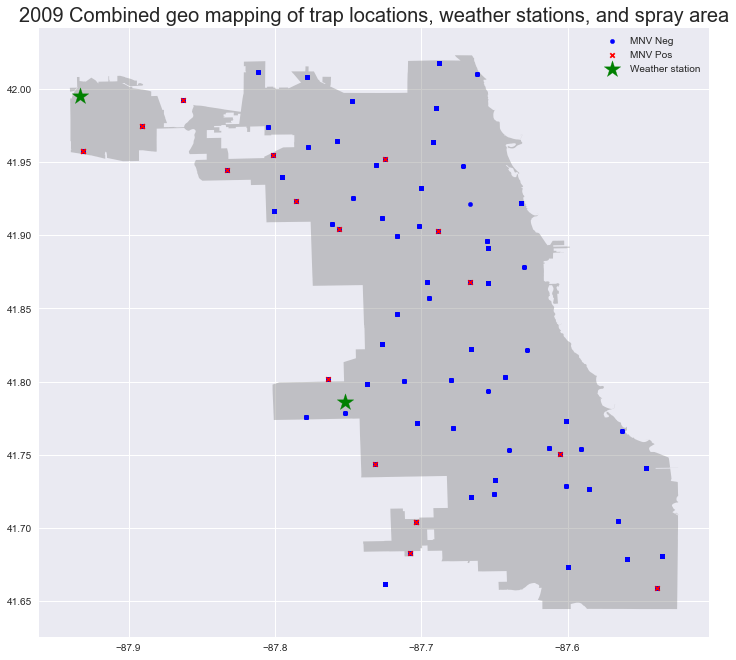

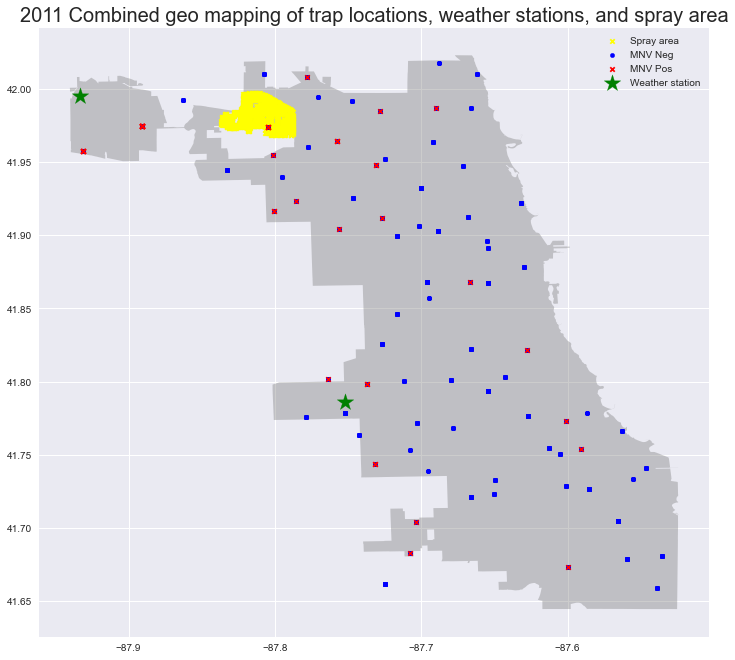

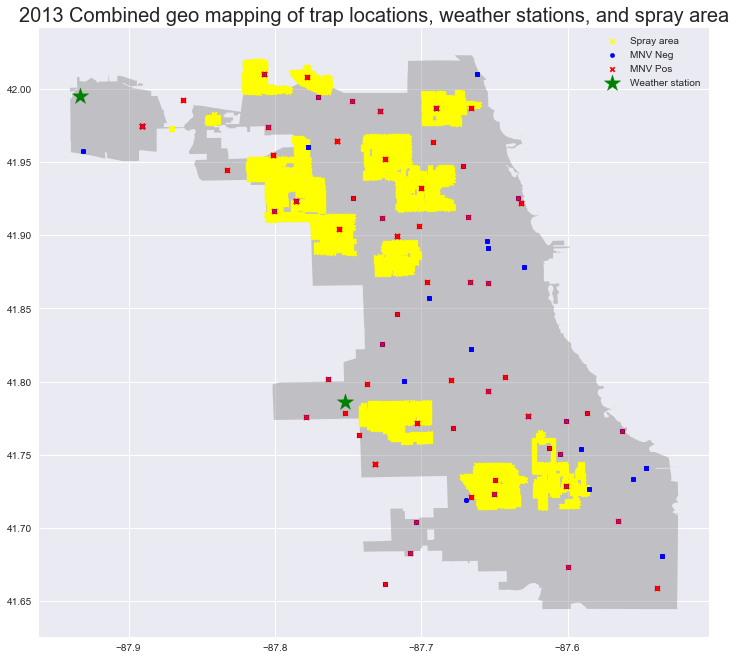

In [96]:
# Loop to plot the traps across years
for i, yr in enumerate(list(train_df['year'].unique())):
    fig, ax = plt.subplots(figsize = (12,12))
    neg_mask = (geo_df['year'] == yr) & (geo_df['wnvpresent']==0)
    pos_mask = (geo_df['year'] == yr) & (geo_df['wnvpresent']==1)
    
    street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
    if len(geo_spray[geo_spray['year']==yr]):
        geo_spray[geo_spray['year']==yr].plot(ax=ax, markersize=20, color='yellow',marker='x', label='Spray area')
    geo_df[neg_mask].plot(ax=ax, markersize=20, color='blue',marker='o', label='MNV Neg')
    geo_df[pos_mask].plot(ax=ax, markersize=20, color='red',marker='x', label='MNV Pos')
    geo_stn.plot(ax=ax, markersize=300, color='green', marker='*', label='Weather station');
    plt.title(f'{yr} Combined geo mapping of trap locations, weather stations, and spray area', fontdict={'fontsize':20})
    plt.legend();
    
# Combined geo mapping of trap locations, 2 weather stations, and spray area
# Red 'x' - 'WnrPresent' == 1
# Blue 'o' - 'WnrPresent' == 0
# Green '*' - Weather station 1 & 2
# Yellow 'x' - Spray    

---
## EDA visualization
[top](#Contents)

In [97]:
# get list of years in train_df
train_years = list(train_df['year'].unique())
plot_dict = dict()

# split the train_df into years for plotting
for yr in train_years:
    plot_dict[yr] = train_df[train_df['date'].dt.year == yr]

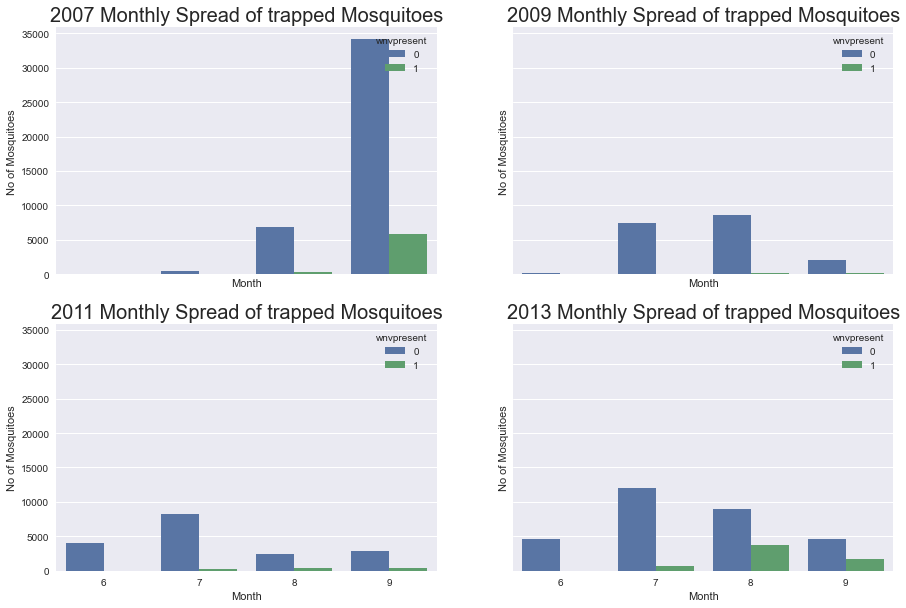

In [98]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10),sharey=True,sharex=True); 
ax = ax.ravel()

for i, yr in enumerate(list(train_df['year'].unique())):
    yr_data = train_df[train_df["date"].dt.year == yr]    
    x = yr_data['date'].dt.month
    y = yr_data['nummosquitos']
    c = yr_data['wnvpresent']
    title = f'{yr} Monthly Spread of trapped Mosquitoes'
    x_lbl = ('Month')
    y_lbl = ('No of Mosquitoes')

    sns.barplot(x=x, y=y,hue=c, ax=ax[i], estimator=sum, ci=None);
    ax[i].set_title(title,fontsize=20);
    ax[i].set_xlabel(x_lbl);
    ax[i].set_ylabel(y_lbl);

(0.0, 500.0)

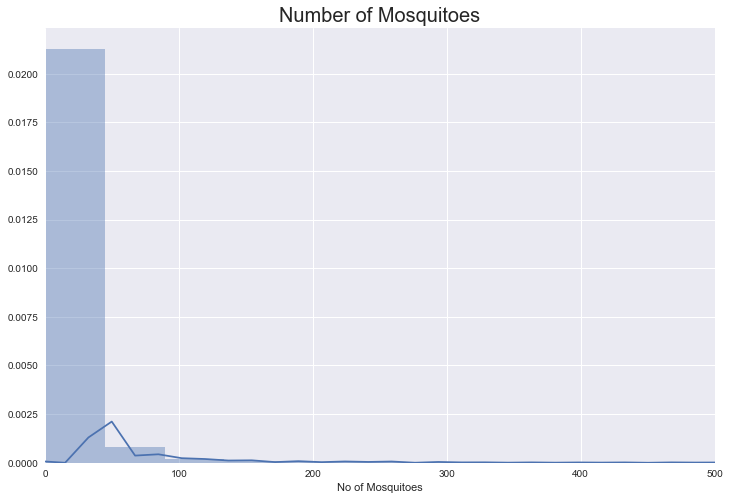

In [99]:
fig, ax = plt.subplots(figsize=(12,8));
sns.distplot(train_df['nummosquitos'], ax=ax);
ax.set_title('Number of Mosquitoes', fontsize = 20);
ax.set_xlabel('No of Mosquitoes');
ax.set_xlim(left=0, right=500)

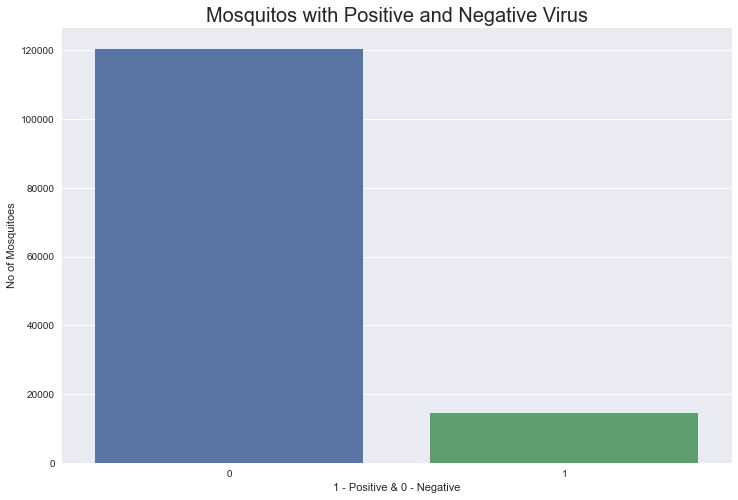

In [100]:
# Positive & Negative Mosqitos across the train dataset
fig, ax = plt.subplots(figsize=(12,8));
sns.barplot(y='nummosquitos',x='wnvpresent', data=train_df, estimator=sum, ci=None);
ax.set_title('Mosquitos with Positive and Negative Virus', fontsize = 20);
ax.set_xlabel('1 - Positive & 0 - Negative');
ax.set_ylabel('No of Mosquitoes');

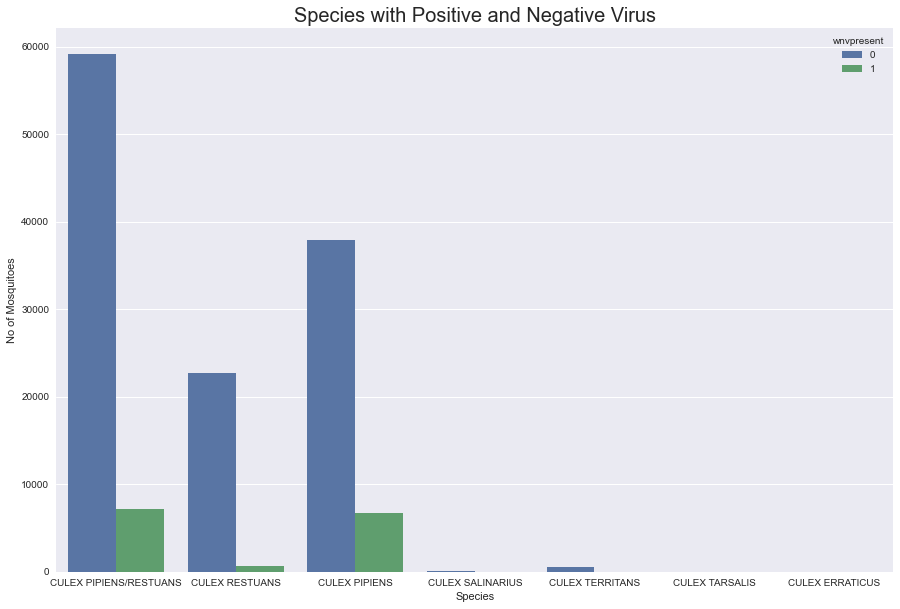

In [101]:
plt.figure(figsize=(15,10));
sns.barplot(x='species', y='nummosquitos',hue='wnvpresent', data=train_df, estimator=sum, ci=None);
plt.title('Species with Positive and Negative Virus', fontsize = 20);
plt.xlabel('Species');
plt.ylabel('No of Mosquitoes');

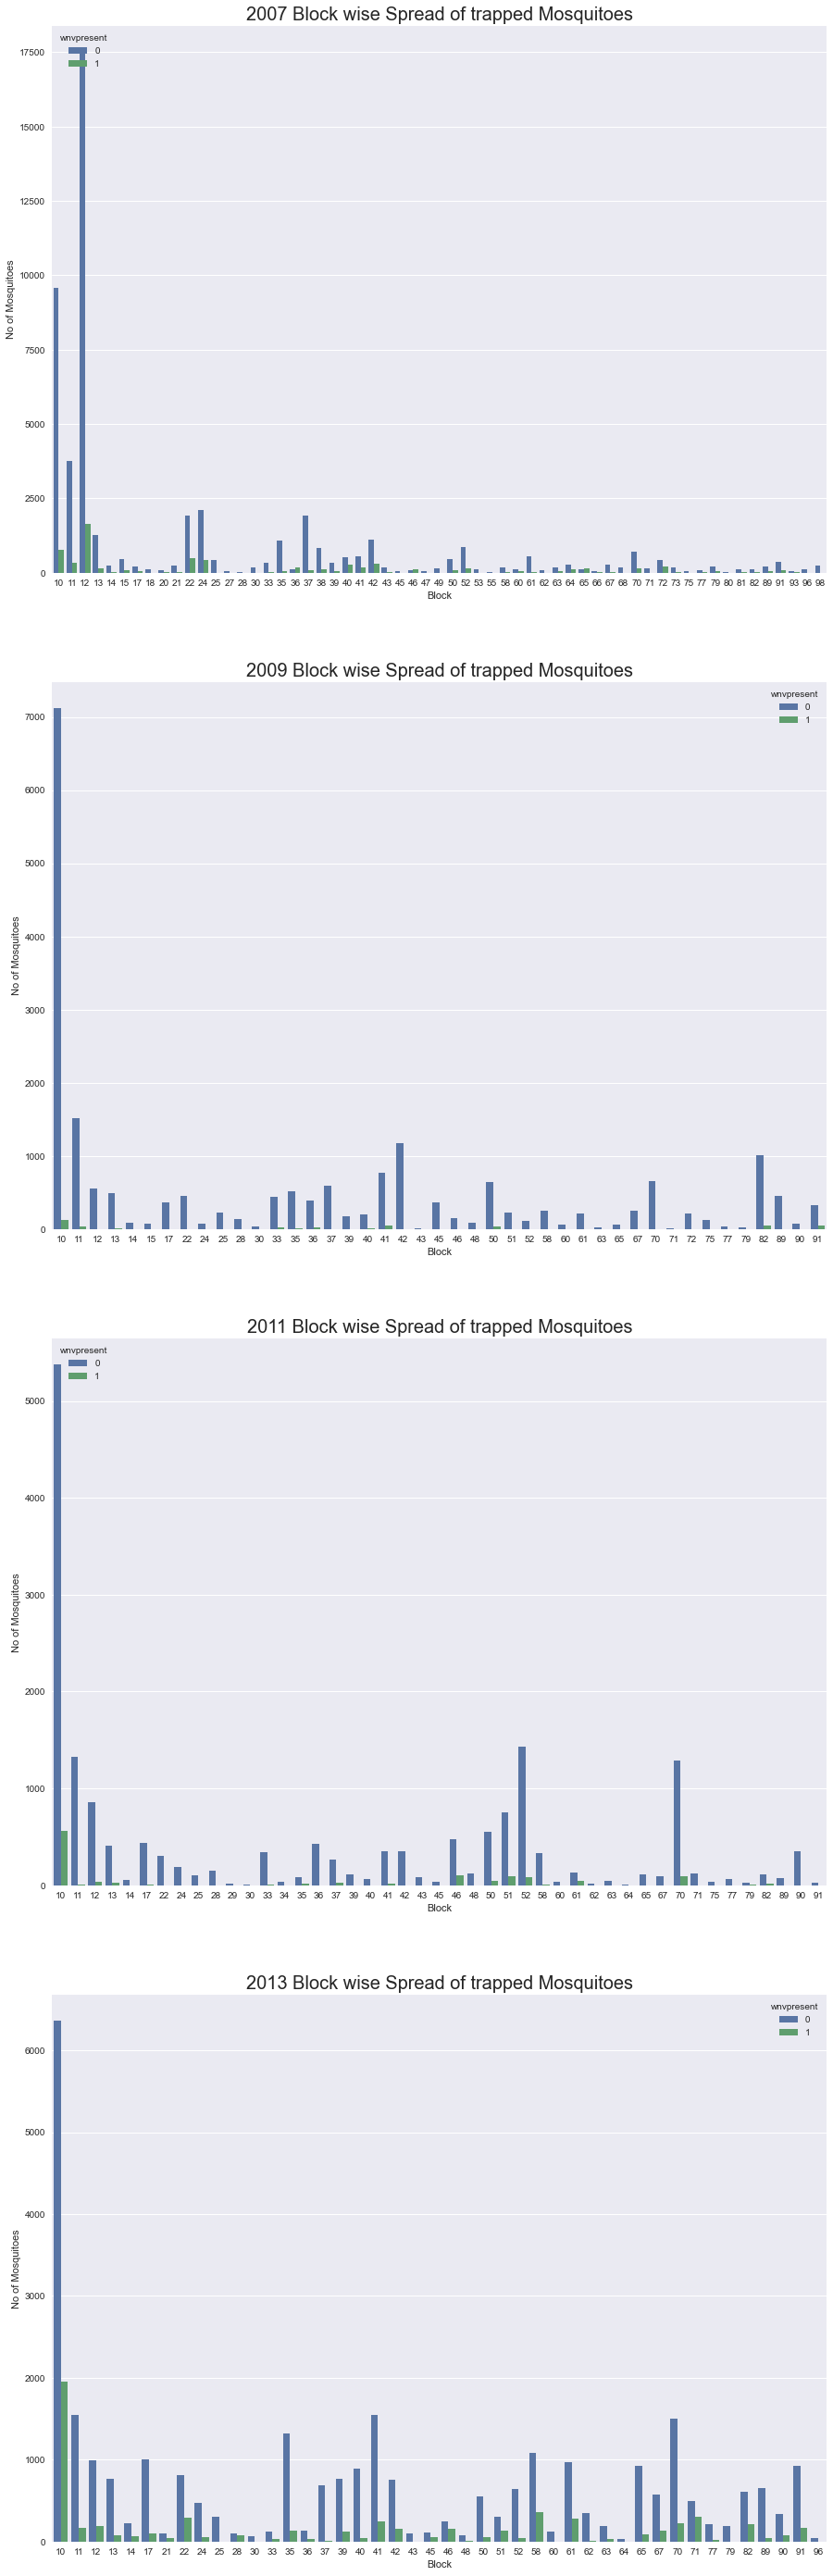

In [102]:
# plot number of mosquitos by block
fig, ax = plt.subplots(nrows=4,figsize=(15,50));
ax = ax.ravel()

for i, yr in enumerate(list(train_df['year'].unique())):
    yr_data = train_df[train_df['date'].dt.year == yr]   
    x = yr_data['block']
    y = yr_data['nummosquitos']
    c = yr_data['wnvpresent']
    title = f'{yr} Block wise Spread of trapped Mosquitoes'
    x_lbl = ('Block')
    y_lbl = ('No of Mosquitoes')
    orient = 'v'

    sns.barplot(x=x, y=y, hue=c, ax=ax[i], orient=orient, estimator=sum, ci=None);
    ax[i].set_title(title, fontsize=20);
    ax[i].set_xlabel(x_lbl);
    ax[i].set_ylabel(y_lbl);

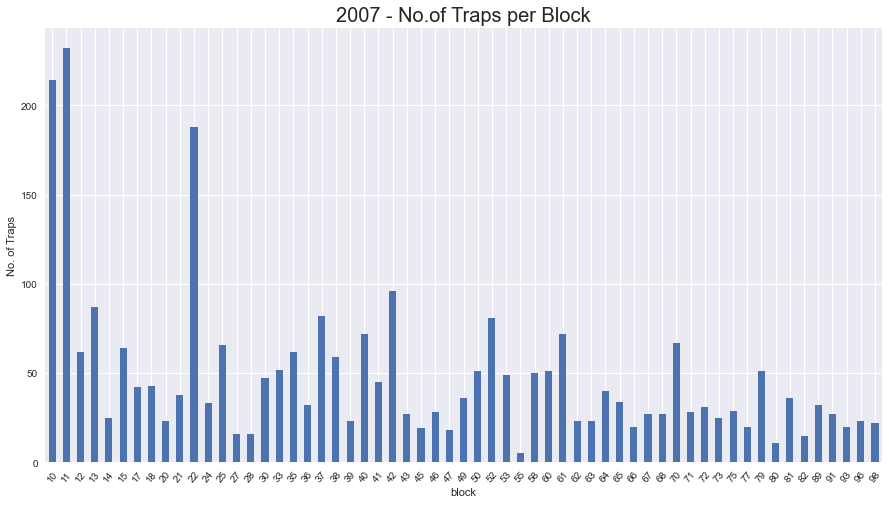

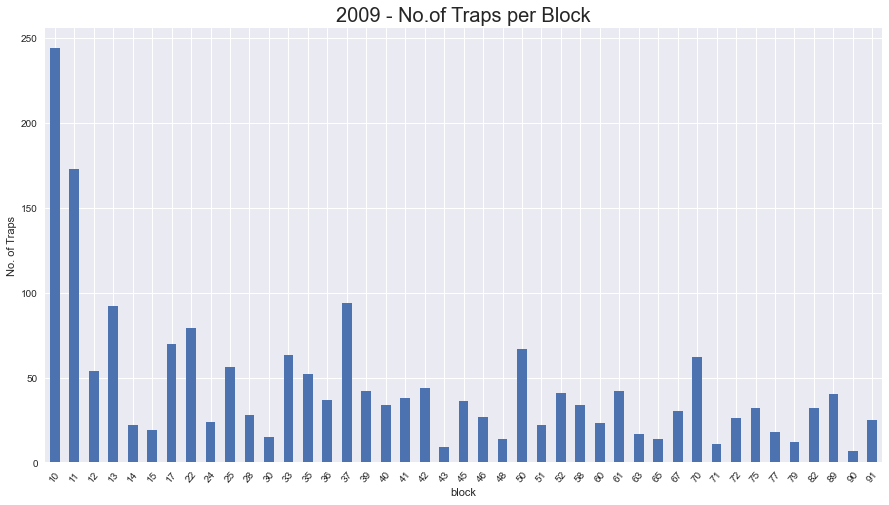

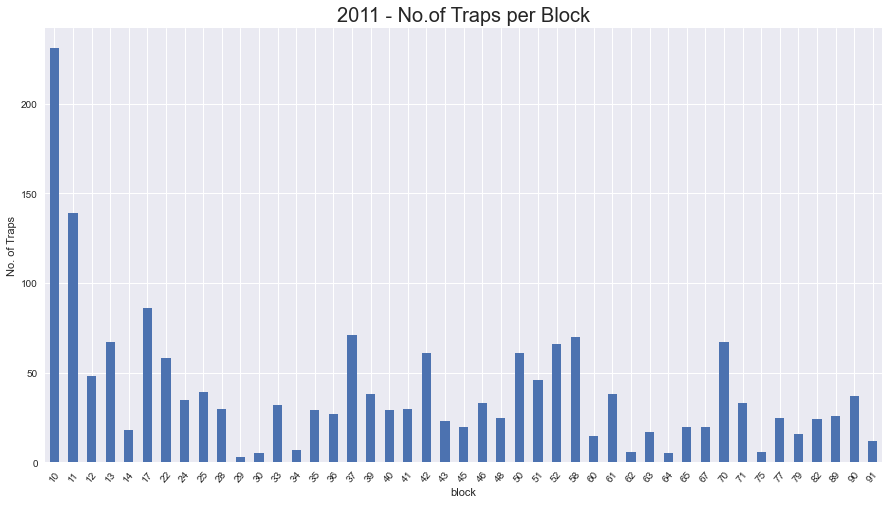

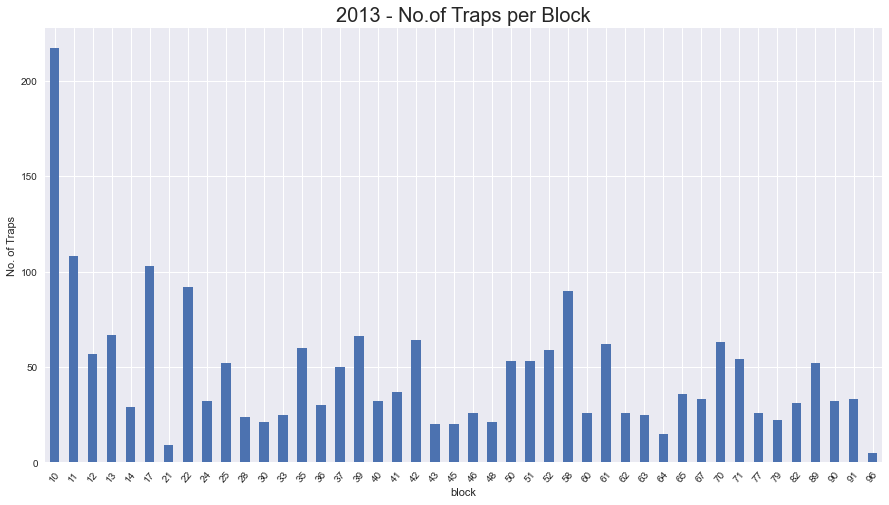

In [103]:
# plot number of traps by block
for i, yr in enumerate(list(train_df['year'].unique())):
    plt.figure(figsize=(15,8))
    plot_data = train_df.groupby(['year','block'])['trap'].count()
    plot_data[yr].plot.bar();
    plt.title(f'{yr} - No.of Traps per Block', fontsize=20);
    plt.ylabel('No. of Traps');
    plt.xticks(rotation=50);

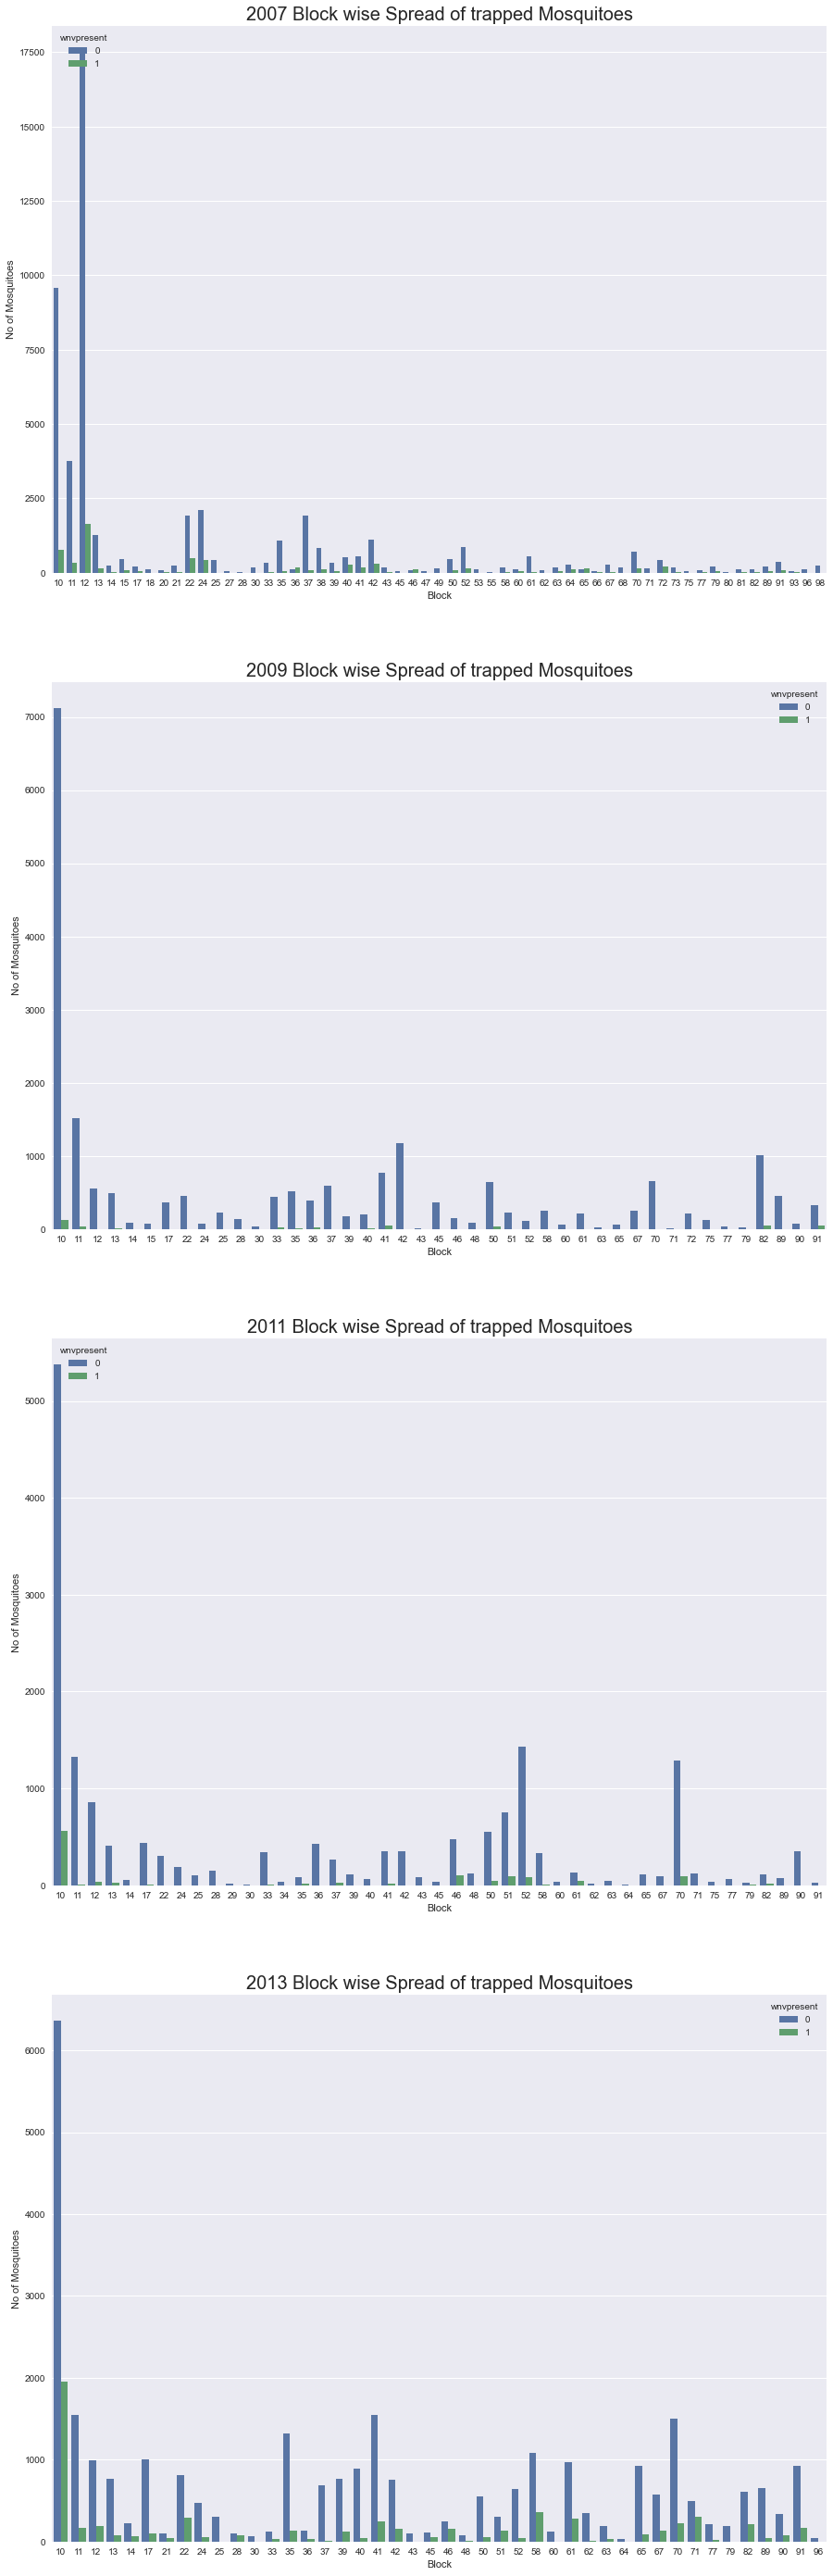

In [104]:
# plot number of traps by block in 2007
fig, ax = plt.subplots(nrows=4,figsize=(15,50));
ax = ax.ravel()

for i, yr in enumerate(list(train_df['year'].unique())):
    yr_data = train_df[train_df['date'].dt.year == yr]   
    x = yr_data['block']
    y = yr_data['nummosquitos']
    c = yr_data['wnvpresent']
    title = f'{yr} Block wise Spread of trapped Mosquitoes'
    x_lbl = ('Block')
    y_lbl = ('No of Mosquitoes')
    orient = 'v'

    sns.barplot(x=x, y=y, hue=c, ax=ax[i], orient=orient,  estimator=sum, ci=None);
    ax[i].set_title(title, fontsize=20);
    ax[i].set_xlabel(x_lbl);
    ax[i].set_ylabel(y_lbl);

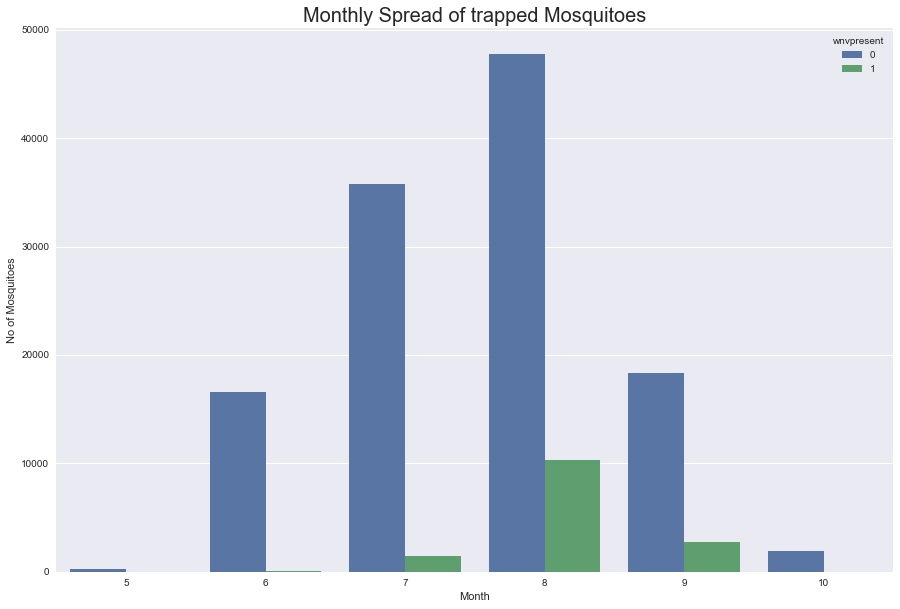

In [105]:
# Monthly trend of trapped mosquitos across all years
fig, ax = plt.subplots(figsize=(15,10));
sns.barplot(x=train_df['date'].dt.month, y='nummosquitos', hue='wnvpresent', 
            data=train_df, estimator=sum, ci=None);
ax.set_title('Monthly Spread of trapped Mosquitoes',fontsize=20);
ax.set_xlabel('Month');
ax.set_ylabel('No of Mosquitoes');

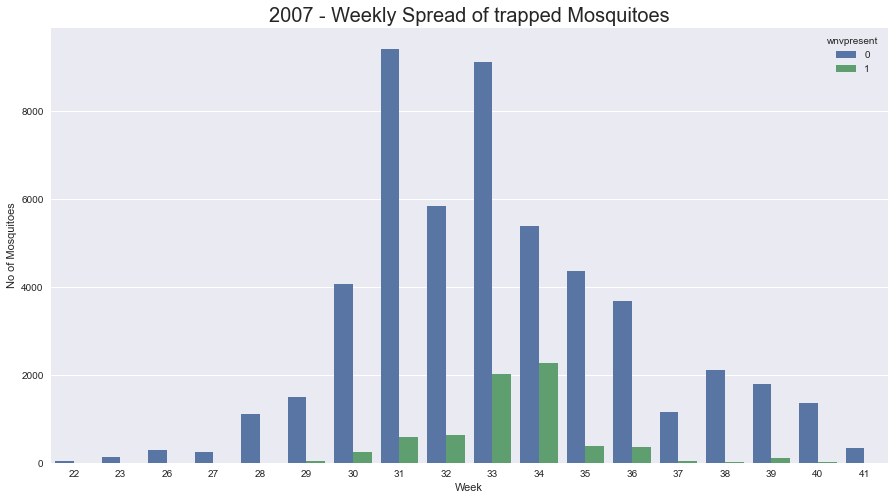

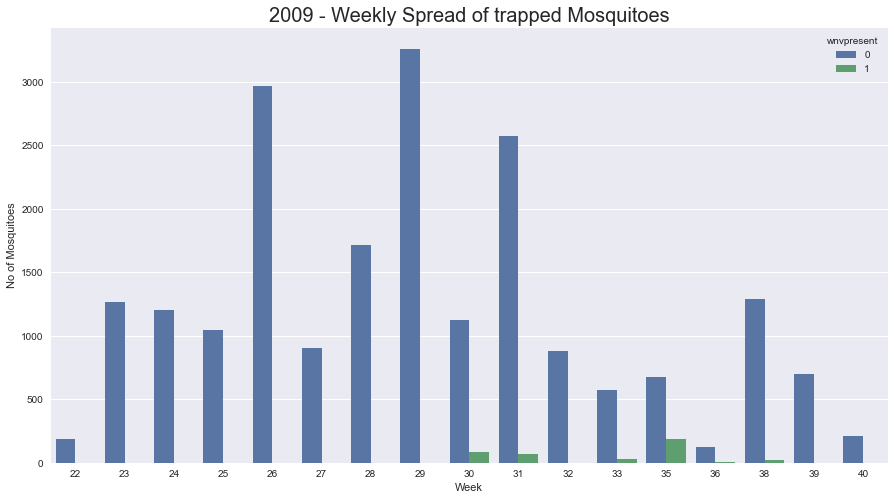

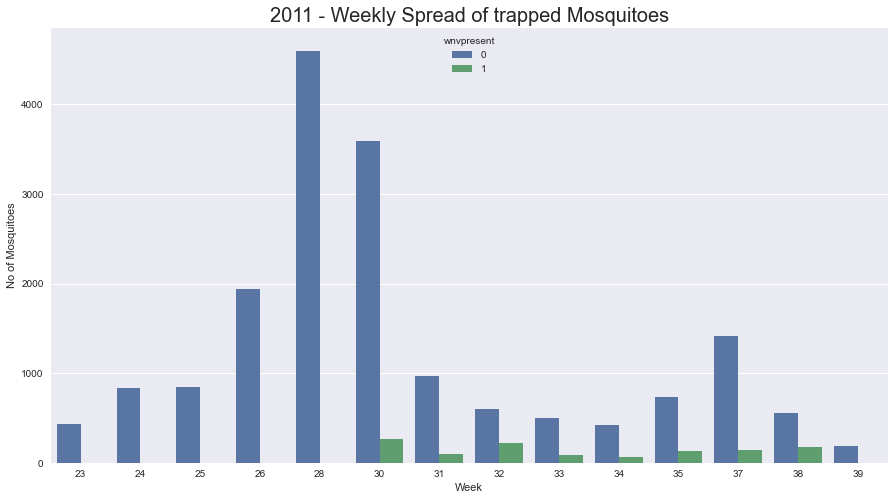

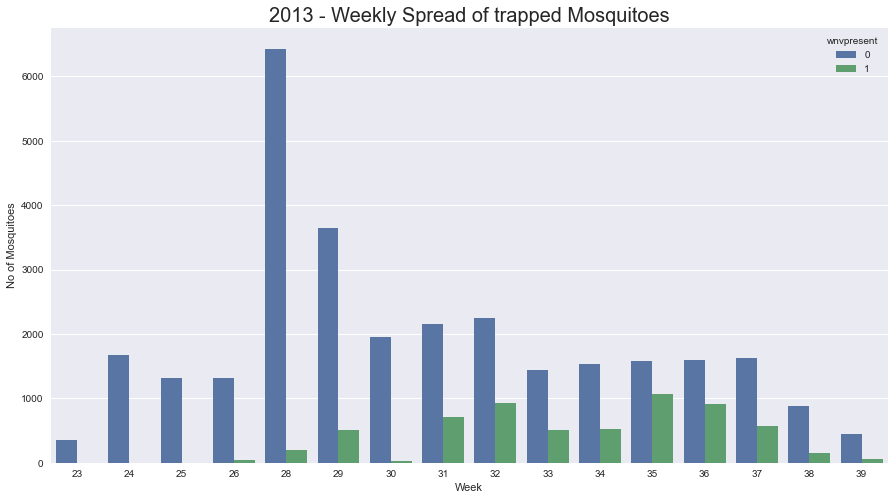

In [106]:
# plot number of mosquitos by block
for i, yr in enumerate(list(train_df['year'].unique())):
    fig, ax = plt.subplots(figsize=(15,8));
    yr_data = train_df[train_df['date'].dt.year == yr]
    sns.barplot(x=yr_data['date'].dt.isocalendar().week, 
                y='nummosquitos', hue='wnvpresent', data=yr_data, estimator=sum, ci=False, ax=ax);
    ax.set_title(f'{yr} - Weekly Spread of trapped Mosquitoes',fontsize=20);
    ax.set_xlabel('Week');
    ax.set_ylabel('No of Mosquitoes');
    plt.show()

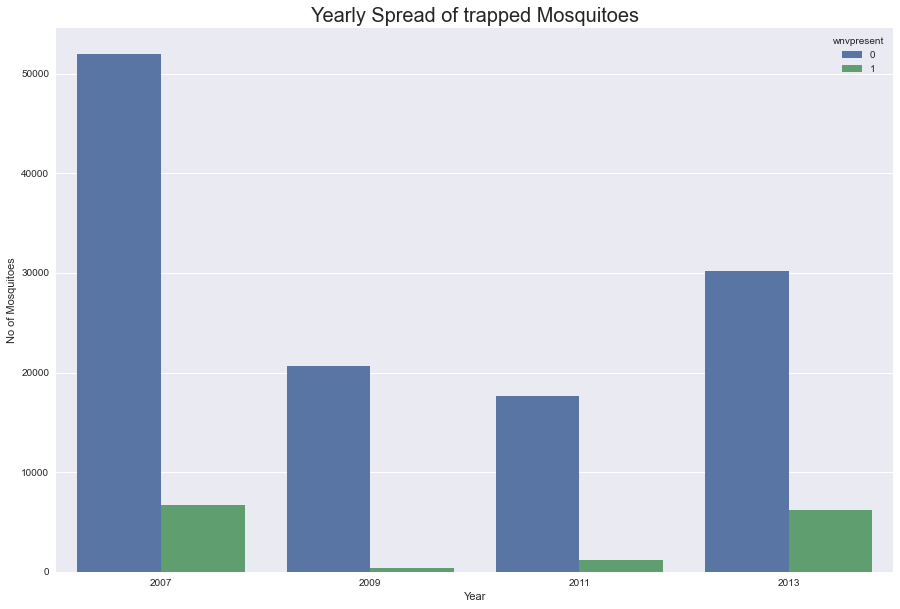

In [107]:
# Yearly trend of trapped mosquitos
fig, ax = plt.subplots(figsize=(15,10));
sns.barplot(x=train_df['date'].dt.year, y='nummosquitos', hue='wnvpresent', data=train_df, estimator=sum, ci=None);
ax.set_title('Yearly Spread of trapped Mosquitoes',fontsize=20);
ax.set_xlabel('Year');
ax.set_ylabel('No of Mosquitoes');

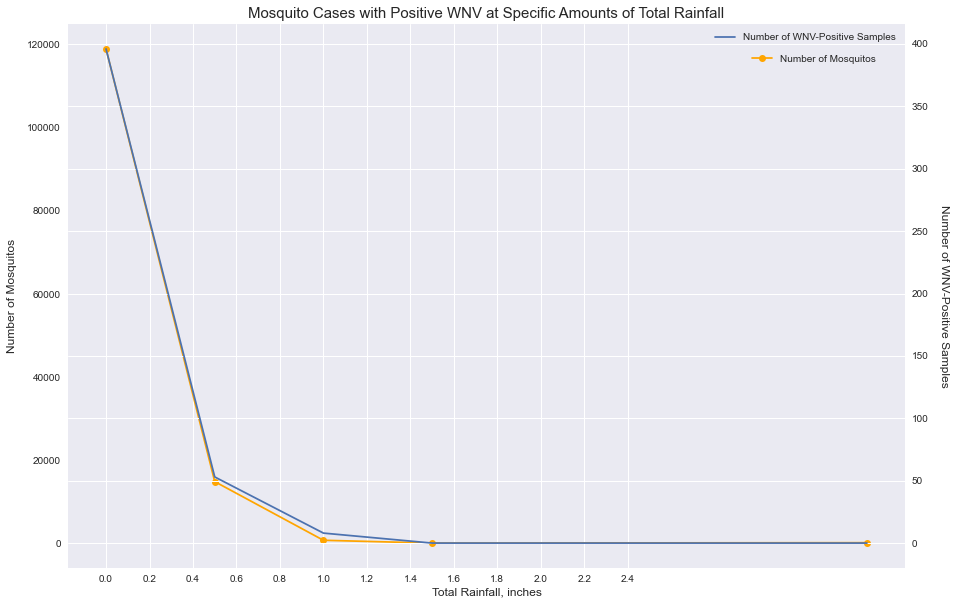

In [108]:
### Impact of Rainfall on Mosquitos Count
def plot_precip(compound):
    fig, ax = plt.subplots(figsize=(15,10))

    # Compound data to specifed scale
    temp = merged_df.groupby('preciptotal').sum()
    temp = temp.groupby(temp.index // compound).sum().reset_index()[['preciptotal', 'wnvpresent', 'nummosquitos']]
    temp.preciptotal = temp.preciptotal * compound

    # Mosquitos Count Plot
    temp.set_index('preciptotal')['nummosquitos'].plot(ax=ax, color='orange', marker='o', label='Number of Mosquitos')
    ax.set_ylabel('Number of Mosquitos', fontsize=12, labelpad=10)
    ax.legend(loc=(0.813, 0.92))
    ax.grid(axis='y')

    # WNV-Positive Traps Plot
    ax2 = ax.twinx()
    temp.set_index('preciptotal')['wnvpresent'].plot(ax=ax2, marker='x', label='Number of WNV-Positive Samples')
    ax2.set_ylabel('Number of WNV-Positive Samples', fontsize=12, labelpad=20, rotation=270)
    ax2.legend(loc=0)

    plt.xticks(np.arange(0, 2.6, 0.2))
    ax.set_xlabel('Total Rainfall, inches', fontsize=12)
    plt.title('Mosquito Cases with Positive WNV at Specific Amounts of Total Rainfall', fontsize=15)
    plt.show()

plot_precip(compound=0.5)

The above line graph shows the total rainfall (precipitation) is inversely proportionatal to both the number of mosquitos and number of WNV-positive traps. 

The numbers are significantly higher when there is no rainfall at all. Furthermore, mosquitoes still thrive at rainfall amounts less than 1.0 inch. After which, the WNV-positive trap counts fall to zero with mosquitos count start to hover around zero.

The observation of precipitation can most likely be attributed to heavy downpour washing away the mosquito larvae at higher amounts of precipitation (rainfall).

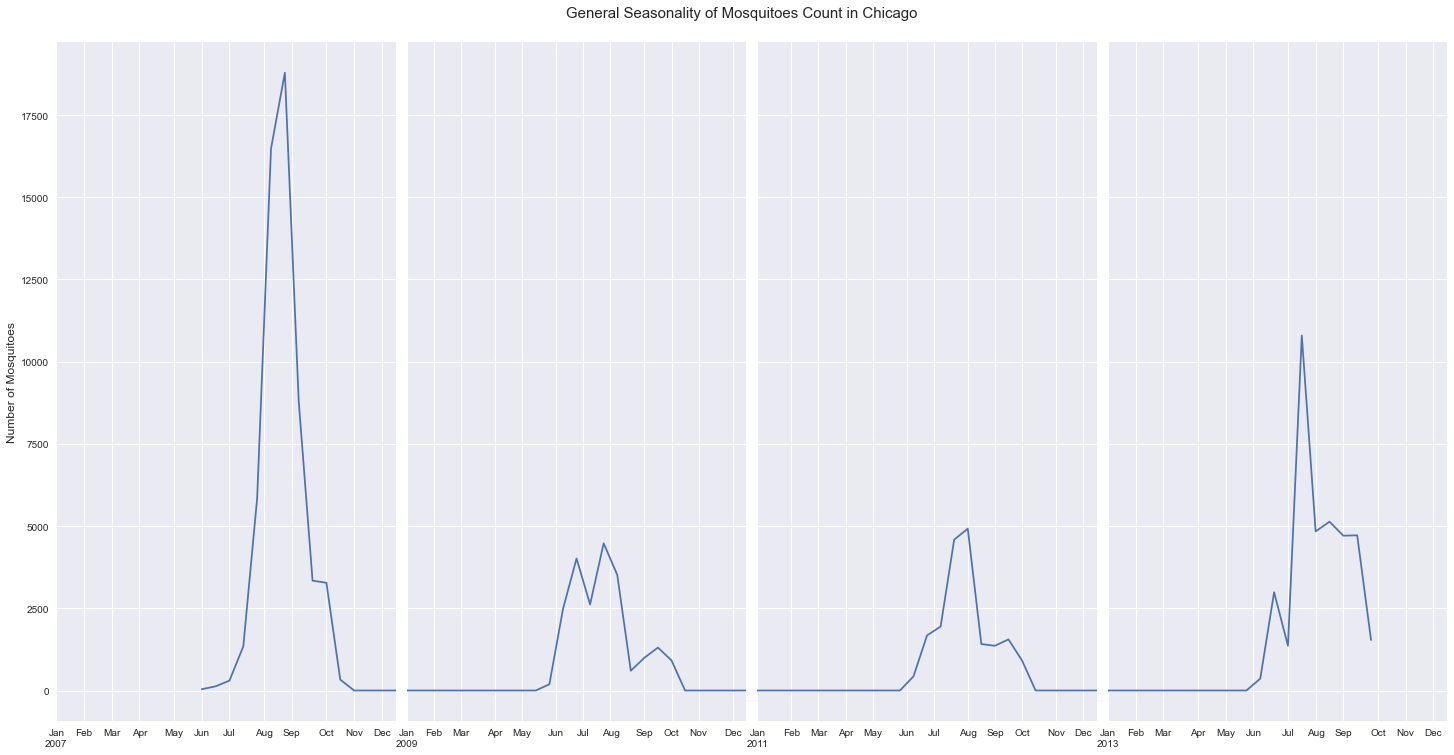

In [109]:
### Annual Seasonality of Mosquito Count in Chicago
fig, ax = plt.subplots(ncols=4, figsize=(20,10), sharey=True)

years = ['2007', '2009', '2011', '2013']

for i in range(4):
    merged_df.set_index('date').resample('2W').sum()['nummosquitos'].sort_index().plot(ax=ax[i])
    ax[i].set_xlim(years[i]+'-01', years[i]+'-12-15')
    ax[i].set_xlabel('')

# Global Setting
fig.suptitle('General Seasonality of Mosquitoes Count in Chicago', x=0.51, y=1.03, fontsize=15)
ax[0].set_ylabel('Number of Mosquitoes', fontsize=12)
plt.tight_layout(pad=0)

plt.show()

The above graph shows that the peak period where mosquitoes start to breed is the months between Jun- Oct every year, most likely following the change of seasons.

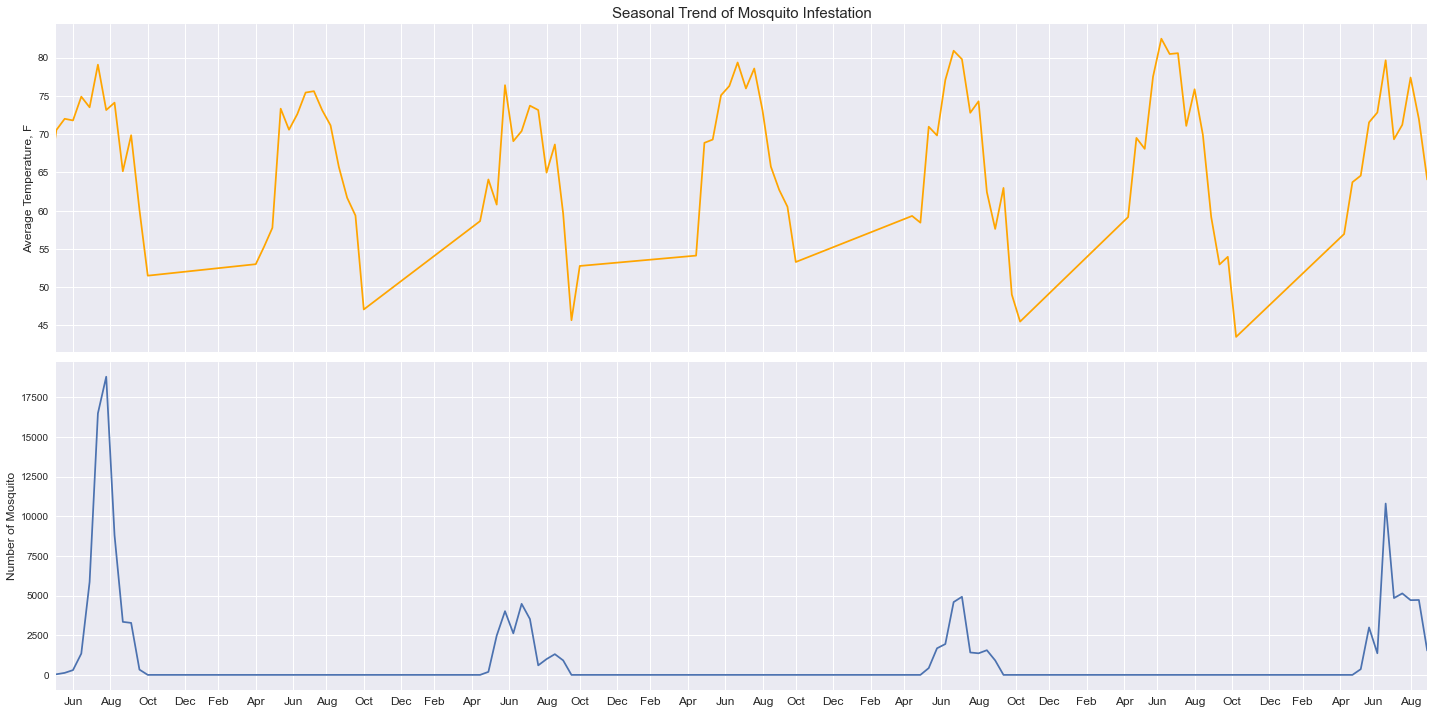

In [110]:
### Temperature Seasonality on Mosquitoes Count
fig, ax = plt.subplots(nrows=2, figsize=(20,10), sharex=True)

# Temperature resampled at 2-week Interval
w_df.resample('2W').mean()['tavg'].interpolate(method='time').plot(ax=ax[0], 
                                                                   color='orange', 
                                                                   label='Temperature')
ax[0].set_ylabel('Average Temperature, F', fontsize=12)
ax[0].tick_params(axis='x', which='minor', bottom=False)

# Number of Mosquitos
merged_df.set_index('date').resample('2W').sum()['nummosquitos'].interpolate(method='time').plot(ax=ax[1],
                                                                                             label='Mosquito Count')
ax[1].set_ylabel('Number of Mosquito', fontsize=12)

# Global Setting
ax[0].set_title('Seasonal Trend of Mosquito Infestation', fontsize=15)
ax[1].set_xlabel('')
timeframe = pd.date_range('2007-06-01', '2013-10-01', freq='2M')
plt.xticks(ticks=timeframe, labels=[x.strftime('%b') for x in timeframe], fontsize=12)

plt.tight_layout(pad=1)
plt.show()

The above graph shows that mosquitos prefer the higher temperatures as when temperature increase so does the number of mosquitoes. 

Mosquitoes data are missing for the alternate years in the training set, hence there are gaps in the trend line every 2 years.

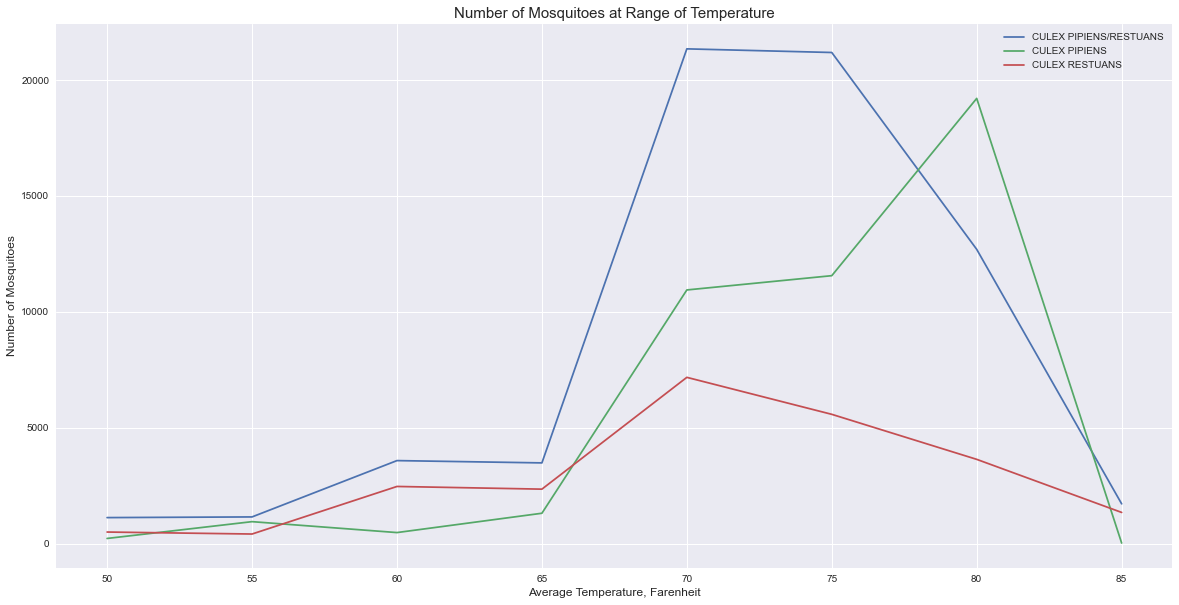

In [111]:
### Optimal Temperature for Mosquitoes Species
def plot_temperature(compound, species=None):
    fig, ax = plt.subplots(figsize=(20,10))

    if species:
        for spec in species:
            # Compound data to specifed scale
            temp = merged_df.groupby('species').get_group(spec).groupby('tavg').sum()
            temp = temp.groupby(temp.index // compound).sum().reset_index()[['tavg', 'nummosquitos']]
            temp.tavg = temp.tavg * compound
            temp.rename(columns={'nummosquitos': spec}, inplace=True)
            temp.set_index('tavg').plot(ax=ax)

    else:
        temp = merged_df.groupby('tavg').sum()
        temp = temp.groupby(temp.index // compound).sum().reset_index()[['tavg', 'nummosquitos']]
        temp.tavg = temp.tavg * compound
        temp.set_index('tavg').plot(ax=ax)
        ax.get_legend().remove()

    # Global Setting
    plt.xlabel('Average Temperature, Farenheit', fontsize=12)
    plt.ylabel('Number of Mosquitoes', fontsize=12)
    plt.title('Number of Mosquitoes at Range of Temperature', fontsize=15)
    plt.show()
    
# Plot of optimal temperature range for each species
species = ['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS']
plot_temperature(compound=5, species=species)

The above graph shows that the top 3 WNV carrying mosquito species prefer a temperature range between 65 degrees Fahrenheit and 85 degrees Fahrenheit.

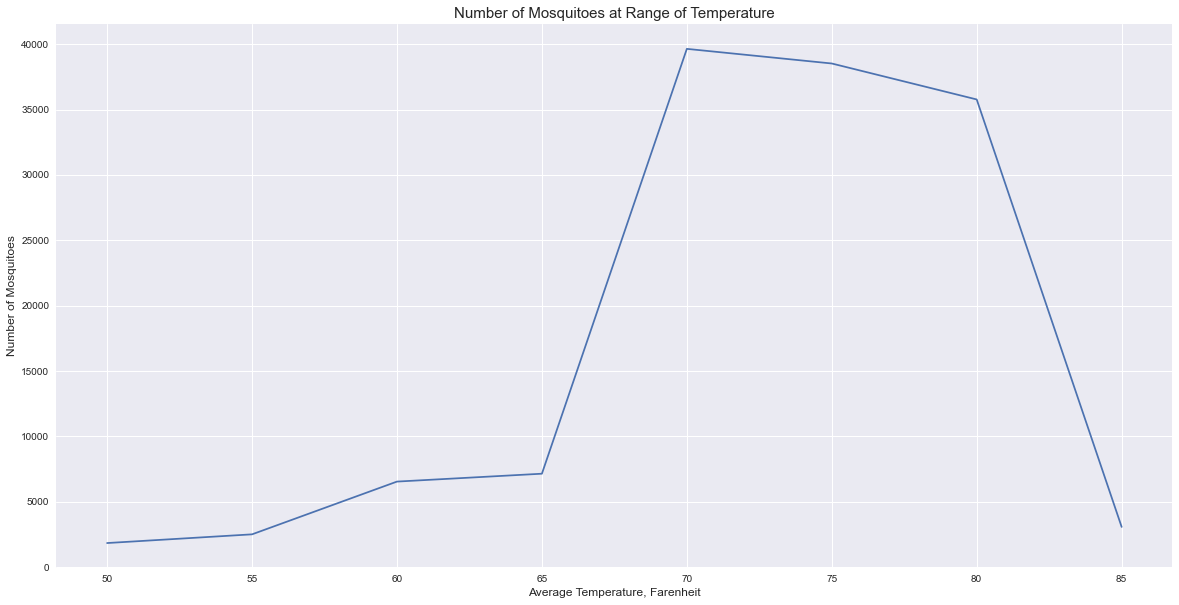

In [112]:
# Plot of optimal temperature range for all mosquitos
plot_temperature(compound=5)

---
## Feature Selection
[top](#Contents)

In [113]:
# Filtering for Numerical Columns
num_df = merged_df.drop(['date', 'latitude', 'longitude'], axis=1)
num_df =  num_df.select_dtypes(include =['float64','int64'])
num_df.shape

(8610, 45)

In [114]:
# Filtering for continuous variables
# Get the number of classes in each columns
unique_counts = num_df.apply(pd.Series.value_counts).notna().sum()

# Getting only continuous variable for correlation study
cont_cols = list(unique_counts[unique_counts>2].index)
# append target feature for correlation analysis
cont_cols.append('wnvpresent')

In [115]:
num_df = num_df[cont_cols]
num_df.head()

,block,addressaccuracy,nummosquitos,year,month,day,stn_distance,tmax,tmin,tavg,...,tmax_wk1,tmin_wk1,tavg_wk1,dewpoint_wk1,wetbulb_wk1,heat_wk1,cool_wk1,preciptotal_wk1,loc,wnvpresent
0,11,8,1,2007,5,29,12.1271,88,65,77.0,...,65.0,49.0,57.0,55.0,56.0,8.0,0.0,1.01,-3669.828863,0
1,11,8,2,2007,5,29,12.1271,88,65,77.0,...,65.0,49.0,57.0,55.0,56.0,8.0,0.0,1.01,-3669.828863,0
2,11,8,1,2007,5,29,12.0456,88,65,77.0,...,65.0,49.0,57.0,55.0,56.0,8.0,0.0,1.01,-3669.182171,0
3,11,8,1,2007,5,29,14.6551,88,65,77.0,...,65.0,49.0,57.0,55.0,56.0,8.0,0.0,1.01,-3672.428319,0
4,15,8,1,2007,5,29,13.5506,88,65,77.0,...,65.0,49.0,57.0,55.0,56.0,8.0,0.0,1.01,-3677.852055,0


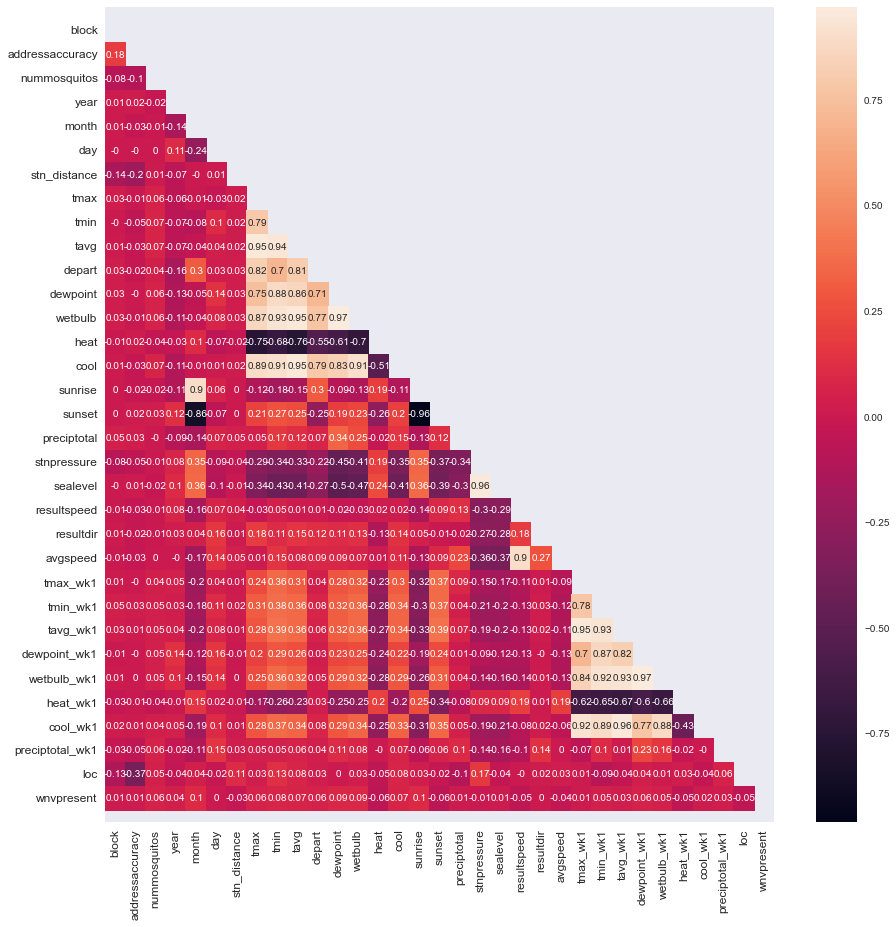

In [116]:
# Plot heat map for all numerical variables in train 
corr=round(num_df.corr(),2)
fix, ax = plt.subplots(figsize=(15,15))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
ax = sns.heatmap(corr,mask=mask, ax=ax, annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, va="center")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top -0.5)

plt.show()

In [117]:
# Loop to remove any collinear variable
correlated_features = set()

# Collinearity threshold here is set at 0.9
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            colname = corr.columns[i]
            correlated_features.add(colname)

print("Collinear Columns to drop: ", correlated_features)

Collinear Columns to drop:  {'cool_wk1', 'tavg', 'wetbulb', 'tavg_wk1', 'cool', 'wetbulb_wk1', 'sunset', 'sealevel'}


In [118]:
num_df = num_df.drop(correlated_features, axis=1)

In [119]:
features = list(num_df.columns)
features.remove('wnvpresent')

In [120]:
# adding the encoded features
features.extend(['cs_tsra', 'cs_ts', 'cs_dz', 'cs_na', 
                 'cs_vcts', 'cs_hz', 'cs_fg',
                 'cs_br', 'cs_ra', 'carrier', 'wetbulb_wk1', 'tavg_wk1', 'cool_wk1'])

In [152]:
len(features)

30

In [122]:
# These 2 columns not in test data
features.remove('nummosquitos')
features.remove('cs_fg')

features.remove('year')
features.remove('stn_distance')

In [123]:
# features = [
#     'stn_distance', 'depart', 'sunrise', 'stnpressure',
#     'resultspeed', 'resultdir', 'avgspeed', 'loc', 'cs_tsra', 
#     'cs_ts', 'cs_dz', 'cs_na', 'cs_vcts',  'cs_hz', 'cs_br', 
#     'cs_ra', 'carrier','tmax_wk1', 'tmin_wk1', 'tavg_wk1', 
#     'dewpoint_wk1', 'wetbulb_wk1', 'heat_wk1', 'cool_wk1',
#     'preciptotal_wk1']

In [124]:
# This set of features is so far giving us the best xgboost score
features = ['block', 'addressaccuracy',
            'year', 'month', 'day', 'stn_distance',
            'depart', 'sunrise', 'stnpressure',
            'resultspeed', 'resultdir', 'avgspeed',
            'loc', 'cs_tsra', 'cs_ts', 'cs_dz', 'cs_na',
            'cs_vcts', 'cs_hz', 'cs_br', 'cs_ra',
            'carrier','tmax_wk1', 'tmin_wk1', 'tavg_wk1',
            'dewpoint_wk1', 'wetbulb_wk1', 'heat_wk1', 'cool_wk1',
            'preciptotal_wk1']

---
## Modelling
[top](#Contents)

In [125]:
# Imbalance class for target feature
merged_df['wnvpresent'].value_counts(normalize=True)

0    0.946922
1    0.053078
Name: wnvpresent, dtype: float64

#### SMOTE
Our negative class of 'wnvpresent' makes up of about 94.7% of our data, which means majority of our traps was tested negative for West Nile Virus. We only have about 5.3% out of 8610 testings that gave us a positive result for the presence of virus. Since our data set is highly imbalanced, we will need to apply Synthetic Minority Over-sampling Technique (SMOTE) to create over-sampling of minority class.

In [126]:
# preparing the features for modelling
X = merged_df[features]
y = merged_df['wnvpresent']

In [127]:
# define constants for modelling
RS = 42 # random state
CV = 5 # cross val
SCORE = 'recall' # scoring 

In [128]:
# list to hold the metrics for each runs
metrics = {}
models = {}

In [129]:
kf = KFold(n_splits=CV, random_state=RS, shuffle=True)

In [130]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RS, stratify=y)

In [131]:
# Function to fit and collect model metrics
def model_metrics(tag, pipe, param, X_tr, X_ts, y_tr, y_ts, models):
    """ 
    Function to fit and collect model metrics
  
    Parameters: 
        tag (str): name for this pipeline
        pipe (pipeline): pipeline to be executed
		param (dict): dictionary of parameters to be used
        X_tr (Series): Series holding the train feature
        X_ts (Series): Series holding the test feature
        y_tr (Series): Series holding the train target
        y_ts (Series): Series holding the test target
  
    Returns: 
		None:
  
    """
    gs = GridSearchCV(pipe, param_grid=param, cv=kf, scoring=SCORE)
    gs.fit(X_tr, y_tr)
    bm = gs.best_estimator_
    models[tag] = gs
    y_pred = bm.predict(X_ts)
    print(f'{tag}->Best params: {gs.best_params_}')
    
    metric = {}
    metric['01 Train score'] = f'{bm.score(X_tr, y_tr):,.4f}'
    metric['02 Test  score'] = f'{bm.score(X_ts, y_ts):,.4f}'
    metric['03 Score diff'] = float(metric['01 Train score'])-float(metric['02 Test  score'])
    metric['04 Train recall'] = f'{recall_score(y_tr, bm.predict(X_tr)):,.4f}'
    metric['05 Test  recall'] = f'{recall_score(y_ts, y_pred):,.4f}'
    print(f'{tag}->Train accuracy score: {metric["01 Train score"]}')
    print(f'{tag}->Test accuracy score: {metric["02 Test  score"]}')

    # calculate Specificity and Sensitivity
    tn, fp, fn, tp = confusion_matrix(y_ts, y_pred).ravel()
    metric['06 Precision'] = f'{(tp /(tp + fp)):.4f}'
    metric['07 Specificity'] = f'{(tn / (tn + fp)):.4f}'
    metric['08 Sensitivity'] = f'{(tp / (tp + fn)):.4f}'
    metric['09 True Negatives'] = tn
    metric['10 False Positives'] = fp
    metric['11 False Negatives'] = fn
    metric['12 True Positives'] = tp
    metric['13 Train ROC Score'] = f'{roc_auc_score(y_tr, bm.predict(X_tr)):,.4f}'
    metric['14 Test ROC Score'] = f'{roc_auc_score(y_ts, bm.predict(X_ts)):,.4f}'
    print(f'{tag}->Precision: {metric["06 Precision"]}')
    print(f'{tag}->Specificity: {metric["07 Specificity"]}')
    print(f'{tag}->Sensitivity: {metric["08 Sensitivity"]}')

    # plot roc and confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    plot_roc_curve(gs, X_ts, y_ts, name=tag, ax=ax[0]);
    # Plot baseline. (Perfect overlap between the two populations.)
    ax[0].plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200),
             label='baseline', linestyle='--')
    plot_confusion_matrix(gs, X_ts, y_ts, ax=ax[1], cmap='RdPu');
    ax[0].set_title(f'ROC for {tag}');
    ax[1].set_title(f'Confusion Matrix for {tag}');
    
    return metric

---
### Logistic Regression

In [132]:
# Creating a pipeline model for StandardScaler, SMOTE and Logistic Regression
lr_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('sm', SMOTE(random_state=RS)),
        ('lr', LogisticRegression(random_state=RS, max_iter=5000))
    ])
# Paramters
lr_params = {'lr__C': np.linspace(0.1, 1, 20)}

lr->Best params: {'lr__C': 0.1}
lr->Train accuracy score: 0.5967
lr->Test accuracy score: 0.6074
lr->Precision: 0.1033
lr->Specificity: 0.5951
lr->Sensitivity: 0.8261


,lr
01 Train score,0.5967
02 Test score,0.6074
03 Score diff,-0.0107
04 Train recall,0.7859
05 Test recall,0.8261
06 Precision,0.1033
07 Specificity,0.5951
08 Sensitivity,0.8261
09 True Negatives,485
10 False Positives,330


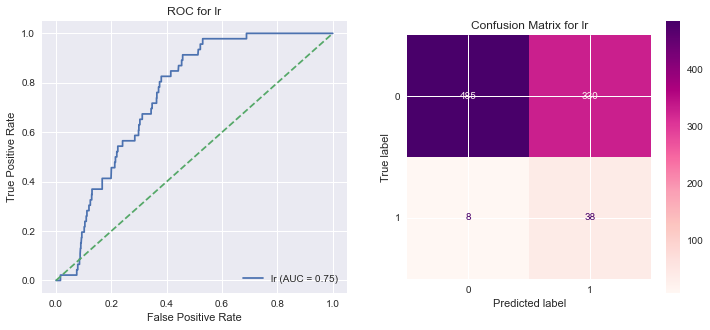

In [133]:
metrics['lr'] = model_metrics('lr', lr_pipe, lr_params, X_train, X_test, y_train, y_test, models)
pd.DataFrame(metrics)

---
### PCA and Logistic Regression

In [134]:
# Creating a pipeline model for StandardScaler, SMOTE, PCA and Logistic Regression
pca_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('sm', SMOTE(random_state=RS)),
        ('pca', PCA()),
        ('lr', LogisticRegression(random_state=RS, max_iter=5000))
    ])
# Paramters
pca_params = {
    'pca__n_components': [0.1, 0.25, 0.5, 0.75, 1],
    'pca__tol': [0.5, 0.75, 1],
    'lr__C': np.linspace(0.1, 1, 10),
}

lr_pca->Best params: {'lr__C': 0.1, 'pca__n_components': 0.5, 'pca__tol': 0.5}
lr_pca->Train accuracy score: 0.5886
lr_pca->Test accuracy score: 0.6074
lr_pca->Precision: 0.0876
lr_pca->Specificity: 0.6037
lr_pca->Sensitivity: 0.6739


,lr,lr_pca
01 Train score,0.5967,0.5886
02 Test score,0.6074,0.6074
03 Score diff,-0.0107,-0.0188
04 Train recall,0.7859,0.6667
05 Test recall,0.8261,0.6739
06 Precision,0.1033,0.0876
07 Specificity,0.5951,0.6037
08 Sensitivity,0.8261,0.6739
09 True Negatives,485,492
10 False Positives,330,323


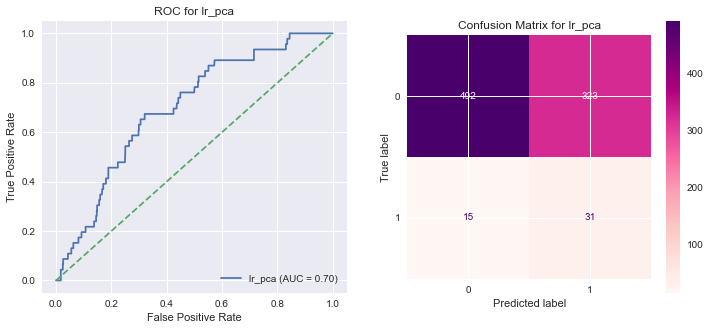

In [135]:
metrics['lr_pca'] = model_metrics('lr_pca', pca_pipe, pca_params, X_train, X_test, y_train, y_test, models)
pd.DataFrame(metrics)

---
### Extra Trees

In [136]:
# Creating a pipeline model for StandardScaler, SMOTE and Extra Trees
et_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('sm', SMOTE(random_state=RS)),
        ('et', ExtraTreesClassifier(random_state=RS, n_jobs=-1))
    ])
# Parameters
et_params = {'et__n_estimators': [500],
             'et__min_samples_split': [2],
             'et__min_samples_leaf': [5],
             'et__ccp_alpha': [0]}

extra_trees->Best params: {'et__ccp_alpha': 0, 'et__min_samples_leaf': 5, 'et__min_samples_split': 2, 'et__n_estimators': 500}
extra_trees->Train accuracy score: 0.8269
extra_trees->Test accuracy score: 0.8130
extra_trees->Precision: 0.1925
extra_trees->Specificity: 0.8147
extra_trees->Sensitivity: 0.7826


,lr,lr_pca,extra_trees
01 Train score,0.5967,0.5886,0.8269
02 Test score,0.6074,0.6074,0.8130
03 Score diff,-0.0107,-0.0188,0.0139
04 Train recall,0.7859,0.6667,0.8273
05 Test recall,0.8261,0.6739,0.7826
06 Precision,0.1033,0.0876,0.1925
07 Specificity,0.5951,0.6037,0.8147
08 Sensitivity,0.8261,0.6739,0.7826
09 True Negatives,485,492,664
10 False Positives,330,323,151


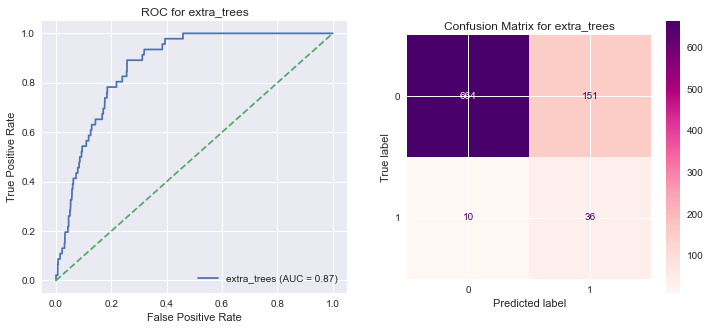

In [137]:
metrics['extra_trees'] = model_metrics('extra_trees', et_pipe, et_params, X_train, X_test, y_train, y_test, models)
pd.DataFrame(metrics)

---
### XGBoost

In [138]:
# Creating a pipeline model for StandardScaler, SMOTE and XGBoost
xgb_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('sm', SMOTE(random_state=RS)),
        ('xgb', XGBClassifier(random_state=RS, 
                              objective= 'binary:logistic', 
                              verbosity=1, n_jobs=-1))#,
                              #booster = 'gblinear'))
    ])
# Parameters
xgb_params = {  'xgb__learning_rate': [0.1],
                'xgb__max_depth': [3],
                'xgb__min_child_weight': [5],
                'xgb__gamma': [0.2],
                'xgb__subsample': [0.8],
                'xgb__scale_pos_weight': [1],
                'xgb__n_estimators': [200]}

xgb->Best params: {'xgb__gamma': 0.2, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 200, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 0.8}
xgb->Train accuracy score: 0.8846
xgb->Test accuracy score: 0.8804
xgb->Precision: 0.2522
xgb->Specificity: 0.8945
xgb->Sensitivity: 0.6304


,lr,lr_pca,extra_trees,xgb
01 Train score,0.5967,0.5886,0.8269,0.8846
02 Test score,0.6074,0.6074,0.8130,0.8804
03 Score diff,-0.0107,-0.0188,0.0139,0.0042
04 Train recall,0.7859,0.6667,0.8273,0.6180
05 Test recall,0.8261,0.6739,0.7826,0.6304
06 Precision,0.1033,0.0876,0.1925,0.2522
07 Specificity,0.5951,0.6037,0.8147,0.8945
08 Sensitivity,0.8261,0.6739,0.7826,0.6304
09 True Negatives,485,492,664,729
10 False Positives,330,323,151,86


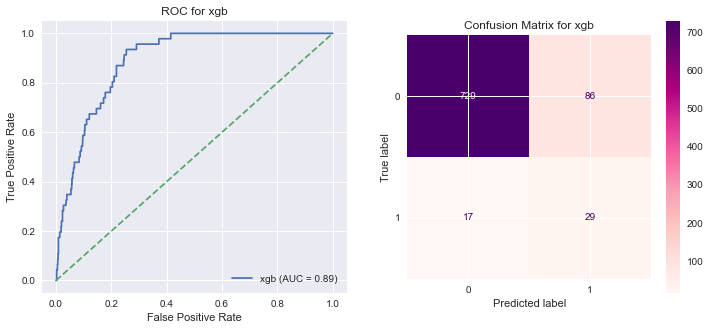

In [139]:
metrics['xgb'] = model_metrics('xgb', xgb_pipe, xgb_params, X_train, X_test, y_train, y_test, models)
pd.DataFrame(metrics)

---
### Random Forest

In [140]:
# Creating a pipeline model for StandardScaler, SMOTE and Random Forest
rf_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('sm', SMOTE(random_state=RS)),
        ('rf', RandomForestClassifier(random_state=RS))
    ])
# Paratmeters
rf_params = {
    'sm__k_neighbors': [3, 5],
    'rf__max_depth': [None, 3, 4, 5],
    'rf__n_estimators': [100, 150, 200]
}

rf->Best params: {'rf__max_depth': 3, 'rf__n_estimators': 150, 'sm__k_neighbors': 3}
rf->Train accuracy score: 0.6283
rf->Test accuracy score: 0.6074
rf->Precision: 0.1117
rf->Specificity: 0.5902
rf->Sensitivity: 0.9130


,lr,lr_pca,extra_trees,xgb,rf
01 Train score,0.5967,0.5886,0.8269,0.8846,0.6283
02 Test score,0.6074,0.6074,0.8130,0.8804,0.6074
03 Score diff,-0.0107,-0.0188,0.0139,0.0042,0.0209
04 Train recall,0.7859,0.6667,0.8273,0.6180,0.8905
05 Test recall,0.8261,0.6739,0.7826,0.6304,0.9130
06 Precision,0.1033,0.0876,0.1925,0.2522,0.1117
07 Specificity,0.5951,0.6037,0.8147,0.8945,0.5902
08 Sensitivity,0.8261,0.6739,0.7826,0.6304,0.9130
09 True Negatives,485,492,664,729,481
10 False Positives,330,323,151,86,334


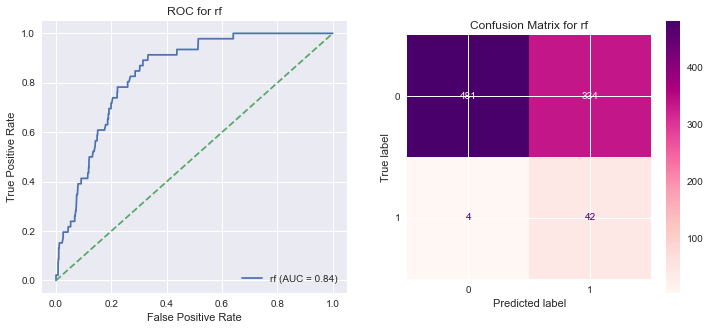

In [141]:
metrics['rf'] = model_metrics('rf', rf_pipe, rf_params, X_train, X_test, y_train, y_test, models)
pd.DataFrame(metrics)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

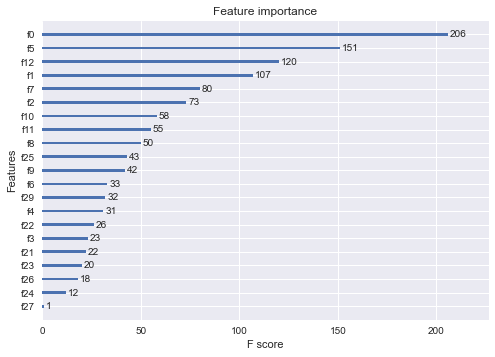

In [142]:
# plot feature importance
xgb=models['xgb'].best_estimator_['xgb']

#xgb.feature_names = features
plot_importance(xgb);

---
## Kaggel submission

Preparing test data for prediction

In [143]:
# get nearest weather station for test_df
nearest_stn(test_df)

In [144]:
# check on shape before merging
print(f'test_df before merge shape: {test_df.shape}')
print(f'w_df shape:\t{w_df.shape}')
# merging of test_df and w_df 
merged_test_df = pd.merge(test_df, w_df, on=['date','station'], right_index=True)
print(f'merged_test_df shape: {merged_test_df.shape}')

test_df before merge shape: (116293, 12)
w_df shape:	(2888, 31)
merged_test_df shape: (116293, 42)


In [145]:
# encoding the features
codesum_encode(merged_test_df)
features_encode(merged_test_df, pos_traps)

unique codesum to be encoded to columns ['vcts', 'na', 'hz', 'dz', 'br', 'ra', 'bcfg', 'fg+', 'tsra', 'ts']


In [146]:
# Test Data from Kaggle
X_tst = merged_test_df[features]

In [147]:
# Get prediction for Test data
y_tst_preds = models['xgb'].best_estimator_.predict(X_tst)

In [148]:
# Generate Kaggle submission file
submission = pd.DataFrame({
        "Id": X_tst.index,
        "WnvPresent": y_tst_preds
    })

submission.to_csv(data_files['submit'], index=False)

In [150]:
merged_test_df['wnvpresent'] = y_tst_preds

In [154]:
# Converting Latitude and Longitude to geo points
geo_tst = [Point(xy) for xy in zip(merged_test_df['longitude'], merged_test_df['latitude'])]
# Creating a GeoDataFrame for merged_test_df data
geo_tst_df = gpd.GeoDataFrame(merged_test_df, crs=crs, geometry=geo_tst)

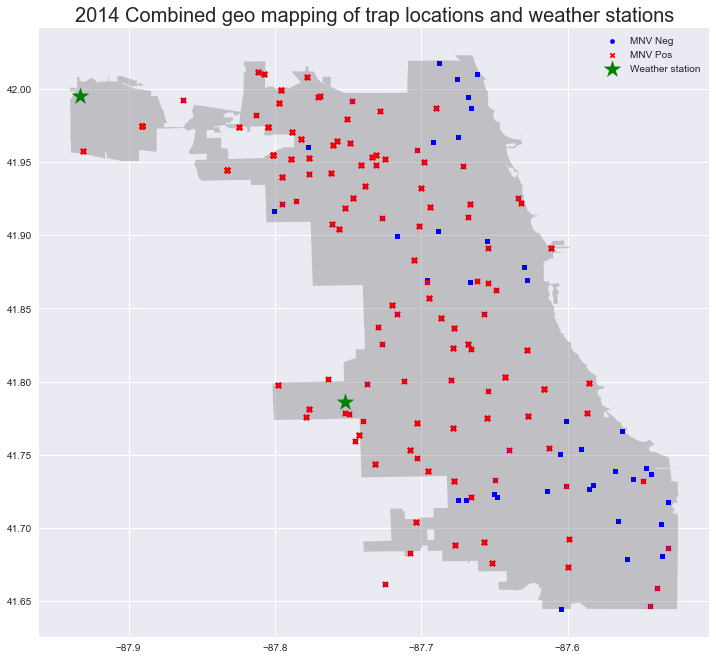

In [159]:
# Loop to plot the traps across years
yr=2014
fig, ax = plt.subplots(figsize=(12,12))
neg_mask = (geo_tst_df['year']==yr) & (geo_tst_df['wnvpresent']==0)
pos_mask = (geo_tst_df['year']==yr) & (geo_tst_df['wnvpresent']==1)

street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_tst_df[neg_mask].plot(ax=ax, markersize=20, color='blue',marker='o', label='MNV Neg')
geo_tst_df[pos_mask].plot(ax=ax, markersize=20, color='red',marker='x', label='MNV Pos')
geo_stn.plot(ax=ax, markersize=300, color='green', marker='*', label='Weather station');
plt.title(f'{yr} Combined geo mapping of trap locations and weather stations', fontdict={'fontsize':20})
plt.legend();
    
# Combined geo mapping of trap locations, 2 weather stations, and spray area
# Red 'x' - 'WnrPresent' == 1
# Blue 'o' - 'WnrPresent' == 0
# Green '*' - Weather station 1 & 2
# Yellow 'x' - Spray   

---
## Conclusions
[top](#Contents)